In [1]:
from module import *
import requests
import time
import pandas as pd
import ast
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import silhouette_score
import seaborn as sns
import joblib
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


API Key loaded successfully!


In [2]:
response = requests.get(f"https://rawg.io/api/games?key={rawg_api_key}&page_size=40&token=") 
print("status code: ",response.status_code)
print("Response json structure: ")
print(response.json().keys())

status code:  200
Response json structure: 
dict_keys(['count', 'next', 'previous', 'results', 'seo_title', 'seo_description', 'seo_keywords', 'seo_h1', 'noindex', 'nofollow', 'description', 'filters', 'nofollow_collections'])


In [3]:
print(response.json()["next"])
print(response.json()["count"])
print(len(response.json()["results"]))
print(response.json()["results"][4])

https://api.rawg.io/api/games?key=caaf4a3eaa414efc8b8104222607204c&page=2&page_size=40&token=
865564
40
{'id': 5286, 'slug': 'tomb-raider', 'name': 'Tomb Raider (2013)', 'released': '2013-03-05', 'tba': False, 'background_image': 'https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg', 'rating': 4.05, 'rating_top': 4, 'ratings': [{'id': 4, 'title': 'recommended', 'count': 2356, 'percent': 60.53}, {'id': 5, 'title': 'exceptional', 'count': 992, 'percent': 25.49}, {'id': 3, 'title': 'meh', 'count': 425, 'percent': 10.92}, {'id': 1, 'title': 'skip', 'count': 119, 'percent': 3.06}], 'ratings_count': 3863, 'reviews_text_count': 14, 'added': 16374, 'added_by_status': {'yet': 674, 'owned': 10596, 'beaten': 4192, 'toplay': 263, 'dropped': 538, 'playing': 111}, 'metacritic': 86, 'playtime': 10, 'suggestions_count': 646, 'updated': '2024-03-30T18:27:33', 'user_game': None, 'reviews_count': 3892, 'saturated_color': '0f0f0f', 'dominant_color': '0f0f0f', 'platforms': [{'platfor

In [29]:
# We create a list to store the games and we proceed to extend it using the first previous results
games = []
games.extend(response.json()["results"])
len(games)

In [31]:
# In case the api call fails we store a list of next pages to continue where it failed
next_pages = []
next_pages.append(response.json()["next"])

In [4]:
# Retrieve a list of games
next_page = next_pages[-1]
while next_page:
    time.sleep(1)
    response = requests.get(next_page)
    
    if response.status_code == 200:
        next_page = response.json()["next"]
        next_pages.append(response.json()["next"])
        if len(response.json()["results"]) > 0:
            for game in response.json()["results"]:
                games.append(game)
        else:
            print("Response returned 0 records")
    else:
        print("Request failed with code: ",response.status_code)

In [47]:
# Last run lasted almost 2 hours with 110,480 records
len(games)

110480

In [49]:
# Create a dataframe using  the games retrieved from the api
df = pd.DataFrame(games)
df.head()

id                             slug                              name  \
0  3498               grand-theft-auto-v                Grand Theft Auto V   
1  3328          the-witcher-3-wild-hunt          The Witcher 3: Wild Hunt   
2  4200                         portal-2                          Portal 2   
3  4291  counter-strike-global-offensive  Counter-Strike: Global Offensive   
4  5286                      tomb-raider                Tomb Raider (2013)   

     released    tba                                   background_image  \
0  2013-09-17  False  https://media.rawg.io/media/games/20a/20aa03a1...   
1  2015-05-18  False  https://media.rawg.io/media/games/618/618c2031...   
2  2011-04-18  False  https://media.rawg.io/media/games/2ba/2bac0e87...   
3  2012-08-21  False  https://media.rawg.io/media/games/736/73619bd3...   
4  2013-03-05  False  https://media.rawg.io/media/games/021/021c4e21...   

   rating  rating_top                                            ratings  \
0    4.47           5  [{'id': 5, 'title': 'exceptional', 'count': 40...   
1    4.65           5  [{'id': 5, 'title': 'exceptional', 'count': 50...   
2    4.61           5  [{'id': 5, 'title': 'exceptional', 'count': 39...   
3    3.57           4  [{'id': 4, 'title': 'recommended', 'count': 16...   
4    4.05           4  [{'id': 4, 'title': 'recommended', 'count': 23...   

   ratings_count  reviews_text_count  added  \
0           6777                  59  20664   
1           6489                  73  19980   
2           5615                  35  18820   
3           3443                  26  16389   
4           3863                  14  16297   

                                     added_by_status  metacritic  playtime  \
0  {'yet': 526, 'owned': 11815, 'beaten': 5888, '...        92.0        74   
1  {'yet': 1115, 'owned': 11499, 'beaten': 4787, ...        92.0        45   
2  {'yet': 614, 'owned': 11617, 'beaten': 5477, '...        95.0        11   
3  {'yet': 262, 'owned': 12402, 'beaten': 1025, '...        81.0        65   
4  {'yet': 674, 'owned': 10518, 'beaten': 4193, '...        86.0        10   

   suggestions_count              updated user_game  reviews_count  \
0                431  2024-04-04T09:23:28      None           6878   
1                675  2024-04-05T08:46:03      None           6595   
2                550  2024-04-04T09:25:19      None           5668   
3                587  2024-04-04T09:24:02      None           3478   
4                646  2024-03-30T18:27:33      None           3892   

  saturated_color dominant_color  \
0          0f0f0f         0f0f0f   
1          0f0f0f         0f0f0f   
2          0f0f0f         0f0f0f   
3          0f0f0f         0f0f0f   
4          0f0f0f         0f0f0f   

                                           platforms  \
0  [{'platform': {'id': 4, 'name': 'PC', 'slug': ...   
1  [{'platform': {'id': 186, 'name': 'Xbox Series...   
2  [{'platform': {'id': 16, 'name': 'PlayStation ...   
3  [{'platform': {'id': 4, 'name': 'PC', 'slug': ...   
4  [{'platform': {'id': 18, 'name': 'PlayStation ...   

                                    parent_platforms  \
0  [{'platform': {'id': 1, 'name': 'PC', 'slug': ...   
1  [{'platform': {'id': 1, 'name': 'PC', 'slug': ...   
2  [{'platform': {'id': 1, 'name': 'PC', 'slug': ...   
3  [{'platform': {'id': 1, 'name': 'PC', 'slug': ...   
4  [{'platform': {'id': 1, 'name': 'PC', 'slug': ...   

                                              genres  \
0  [{'id': 4, 'name': 'Action', 'slug': 'action',...   
1  [{'id': 4, 'name': 'Action', 'slug': 'action',...   
2  [{'id': 2, 'name': 'Shooter', 'slug': 'shooter...   
3  [{'id': 2, 'name': 'Shooter', 'slug': 'shooter...   
4  [{'id': 4, 'name': 'Action', 'slug': 'action',...   

                                              stores  clip  \
0  [{'id': 290375, 'store': {'id': 3, 'name': 'Pl...  None   
1  [{'id': 354780, 'store': {'id': 5, 'name': 'GO...  None   
2  [{'id': 465889, 'store': {'id': 2, 'na

In [51]:
print("shape: ",df.shape)
print(df.dtypes)
df.columns

shape:  (110480, 30)
id                      int64
slug                   object
name                   object
released               object
tba                      bool
background_image       object
rating                float64
rating_top              int64
ratings                object
ratings_count           int64
reviews_text_count      int64
added                   int64
added_by_status        object
metacritic            float64
playtime                int64
suggestions_count       int64
updated                object
user_game              object
reviews_count           int64
saturated_color        object
dominant_color         object
platforms              object
parent_platforms       object
genres                 object
stores                 object
clip                   object
tags                   object
esrb_rating            object
short_screenshots      object
community_rating      float64
dtype: object


Index(['id', 'slug', 'name', 'released', 'tba', 'background_image', 'rating',
       'rating_top', 'ratings', 'ratings_count', 'reviews_text_count', 'added',
       'added_by_status', 'metacritic', 'playtime', 'suggestions_count',
       'updated', 'user_game', 'reviews_count', 'saturated_color',
       'dominant_color', 'platforms', 'parent_platforms', 'genres', 'stores',
       'clip', 'tags', 'esrb_rating', 'short_screenshots', 'community_rating'],
      dtype='object')

In [2]:
# Export the records to a csv
#df.to_csv("games110480.csv")
# Import csv
data_frame = pd.read_csv("data/games110480.csv")

In [3]:
df2 = clean_format_and_export(data_frame, False)

* Applied first filter, new shape:  (16043, 17)
* Completed string to object and json normalize operations \o/ \o/
* Finished replacing and filtering nans.
* Created export csv file named:  15758_games_formatted_clean.csv
* Finished formatting rating columns
* Created export csv file ready for clustering named:  15758_games_clean_formatted_ready_4_clustering.csv


In [4]:
df2.head()

name    released  \
0                grand theft auto v  2013-09-17   
1          the witcher 3: wild hunt  2015-05-18   
2                          portal 2  2011-04-18   
3  counter-strike: global offensive  2012-08-21   
4                tomb raider (2013)  2013-03-05   

                                    background_image  rating  rating_top  \
0  https://media.rawg.io/media/games/20a/20aa03a1...    4.47         5.0   
1  https://media.rawg.io/media/games/618/618c2031...    4.65         5.0   
2  https://media.rawg.io/media/games/2ba/2bac0e87...    4.61         5.0   
3  https://media.rawg.io/media/games/736/73619bd3...    3.57         4.0   
4  https://media.rawg.io/media/games/021/021c4e21...    4.05         4.0   

   ratings_count  playtime  suggestions_count  reviews_count  platform_name_0  \
0         6777.0      74.0              431.0         6878.0               PC   
1         6489.0      45.0              675.0         6595.0  Xbox Series S/X   
2         5615.0      11.0              550.0         5668.0    PlayStation 3   
3         3443.0      65.0              587.0         3478.0               PC   
4         3863.0      10.0              646.0         3892.0    PlayStation 4   

  platform_name_1  platform_name_2 platform_name_3  platform_name_4  \
0   PlayStation 5  Xbox Series S/X   PlayStation 4    PlayStation 3   
1   PlayStation 5            macOS   PlayStation 4  Nintendo Switch   
2              PC         Xbox 360           Linux            macOS   
3           Linux         Xbox 360   PlayStation 3        undefined   
4           macOS               PC        Xbox One         Xbox 360   

  platform_name_5 platform_name_6  genre_0    genre_1  \
0        Xbox 360        Xbox One   Action  undefined   
1              PC        Xbox One   Action        RPG   
2        Xbox One       undefined  Shooter     Puzzle   
3       undefined       undefined  Shooter  undefined   
4   PlayStation 3       undefined   Action  undefined   

                    tags_extracted  recommend_percentage  
0  ['Singleplayer', 'Multiplayer']                 83.64  
1                 ['Singleplayer']                 86.54  
2  ['Singleplayer', 'Multiplayer']                 90.19  
3                  ['Multiplayer']                 25.82  
4  ['Singleplayer', 'Multiplayer']                 72.04

In [17]:
# Select the numericals
numericals = df2.copy().select_dtypes(np.number)
numericals.head(3)

rating  rating_top  ratings_count  playtime  suggestions_count  \
0    4.47         5.0         6777.0      74.0              431.0   
1    4.65         5.0         6489.0      45.0              675.0   
2    4.61         5.0         5615.0      11.0              550.0   

   reviews_count  recommend_percentage  cluster  
0         6878.0                 83.64        3  
1         6595.0                 86.54        3  
2         5668.0                 90.19        3

In [6]:
# Noticed that removing "reviews_count" column reduces inertia, increases silhouette score and visualizer shows improvements
# numericals.drop(["reviews_count"], axis=1, inplace=True)


In [18]:
corr_df = numericals.corr()
corr_df.columns = numericals.columns

# We print out the columns that has a correlation higher than the threshold 0.70
def filter_high_corr(corr_matrix, threshold=0.70):
    highly_correlated = corr_matrix[abs(corr_matrix) >= threshold]  # Filter directly
    return highly_correlated.stack().reset_index().rename(columns={0: 'correlation'})

high_correlations = filter_high_corr(corr_df)
print(high_correlations)

                 level_0               level_1  correlation
0                 rating                rating     1.000000
1                 rating            rating_top     0.783750
2             rating_top                rating     0.783750
3             rating_top            rating_top     1.000000
4          ratings_count         ratings_count     1.000000
5          ratings_count         reviews_count     0.999972
6               playtime              playtime     1.000000
7      suggestions_count     suggestions_count     1.000000
8          reviews_count         ratings_count     0.999972
9          reviews_count         reviews_count     1.000000
10  recommend_percentage  recommend_percentage     1.000000
11               cluster               cluster     1.000000


In [19]:
# Removing rating_top due to high correlation
numericals.drop(["rating_top"], axis=1, inplace=True, errors="ignore")

In [20]:
# K-Means is a distance based algorithm: we need to scale / normalize:
X_scaled = StandardScaler().fit_transform(numericals)

# Now, all features will have the same weight.
pd.DataFrame(X_scaled).head()

0          1         2         3          4         5         6
0  1.606095  22.614531  0.334785  0.455100  22.694482  1.484044  4.055624
1  1.897832  21.638955  0.076471  1.833466  21.746618  1.599114  4.055624
2  1.833002  18.678355 -0.226380  1.127336  18.641779  1.743943  4.055624
3  0.147411  11.320891  0.254619  1.336351  11.306721 -0.810211  4.055624
4  0.925376  12.743605 -0.235288  1.669644  12.693348  1.023764  4.055624

eps =  0.2 , sample =  4 , silhoutte_score =  -0.5090181788527992


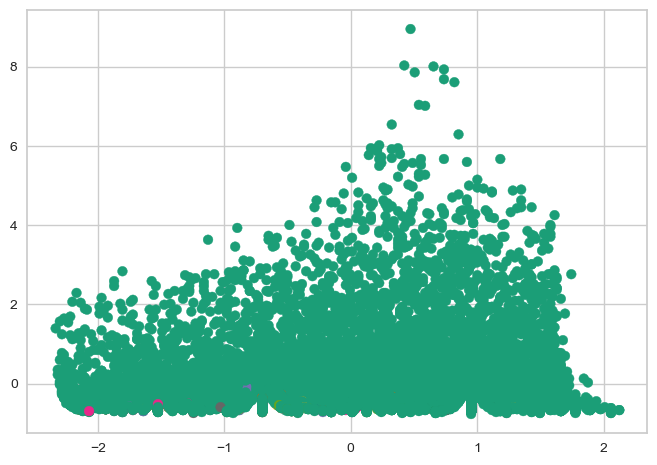

eps =  0.2 , sample =  5 , silhoutte_score =  -0.4969895870366399


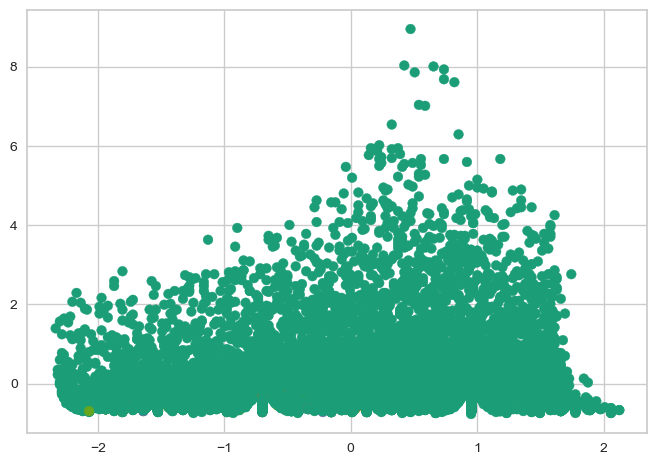

eps =  0.2 , sample =  6 , silhoutte_score =  -0.47174847863804664


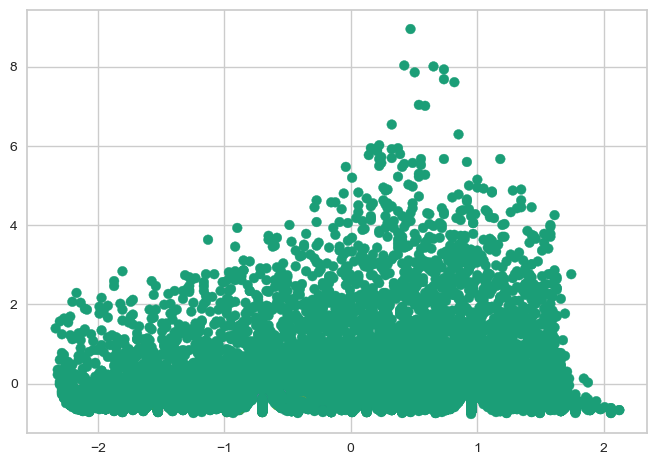

eps =  0.2 , sample =  7 , silhoutte_score =  -0.4408061121737822


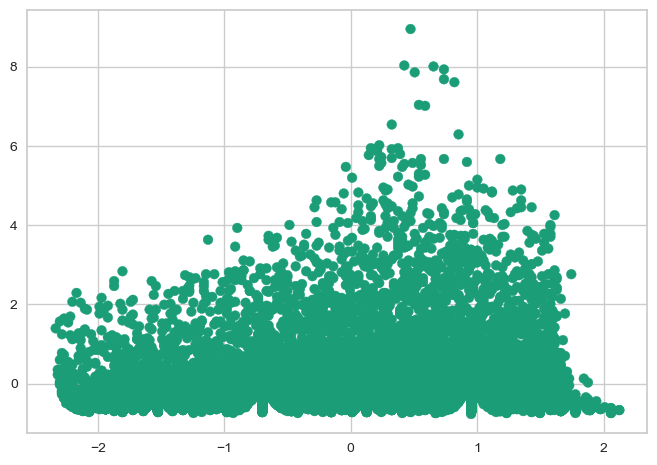

eps =  0.225 , sample =  4 , silhoutte_score =  -0.4831489761119053


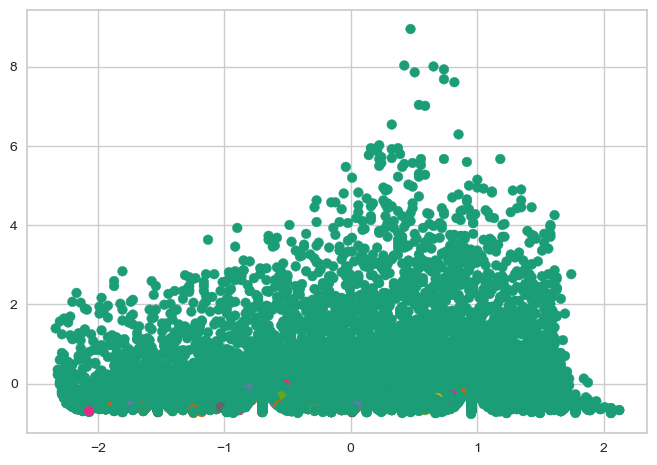

eps =  0.225 , sample =  5 , silhoutte_score =  -0.4772564050060854


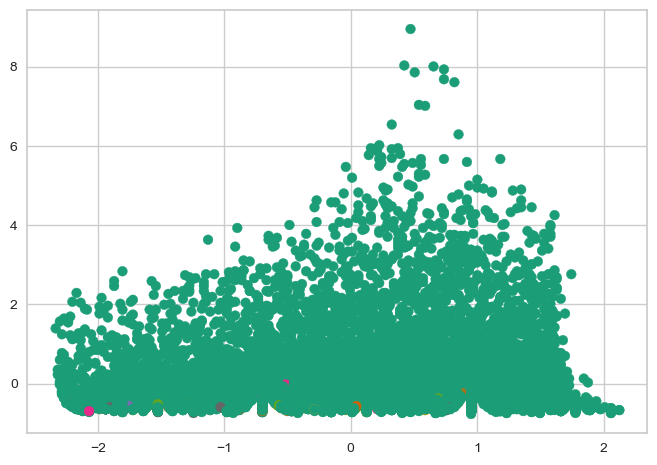

eps =  0.225 , sample =  6 , silhoutte_score =  -0.4901871600213834


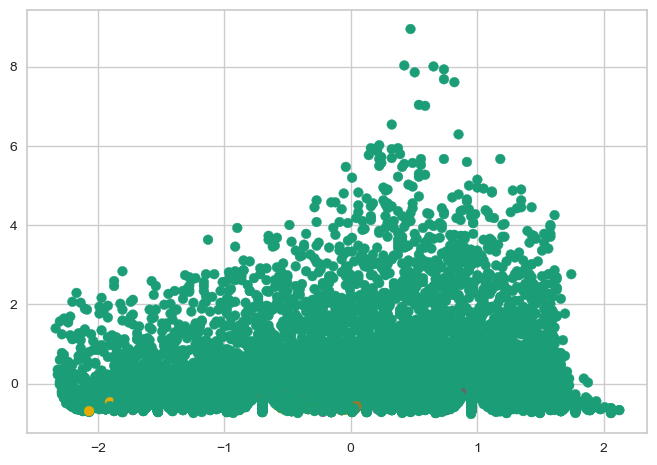

eps =  0.225 , sample =  7 , silhoutte_score =  -0.47380766852922435


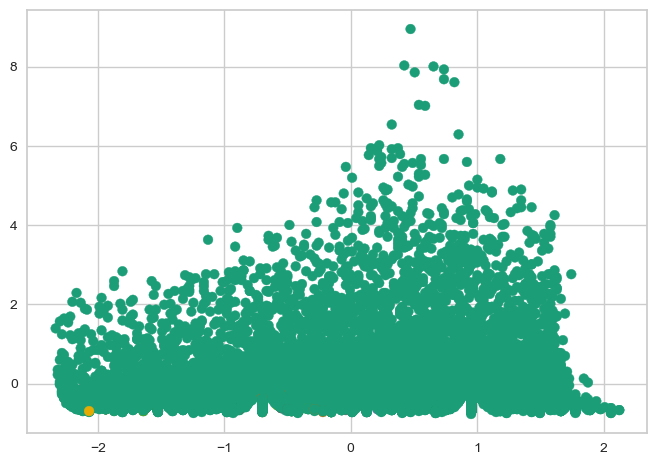

eps =  0.25 , sample =  4 , silhoutte_score =  -0.5230381112116513


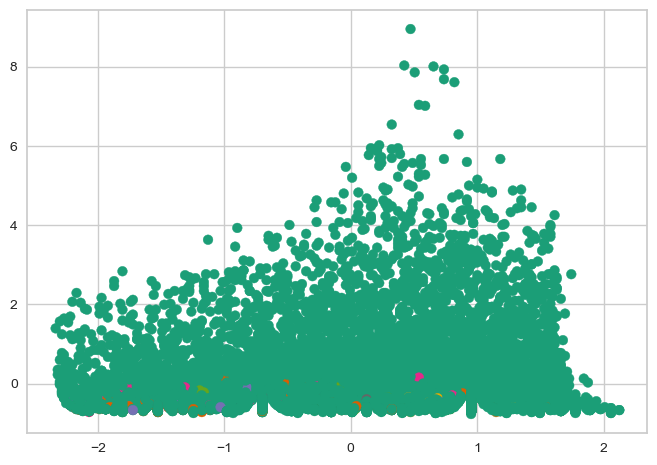

eps =  0.25 , sample =  5 , silhoutte_score =  -0.4777748861977808


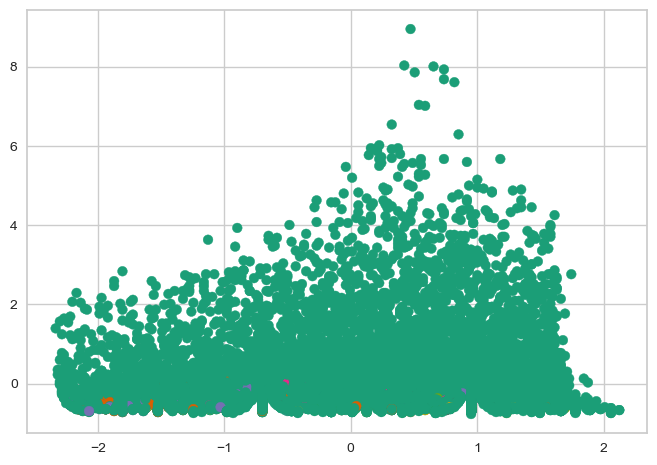

eps =  0.25 , sample =  6 , silhoutte_score =  -0.4605587507346382


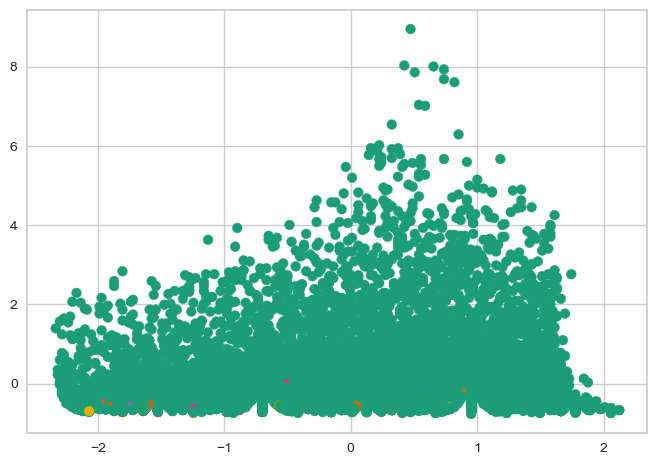

eps =  0.25 , sample =  7 , silhoutte_score =  -0.4670265186576664


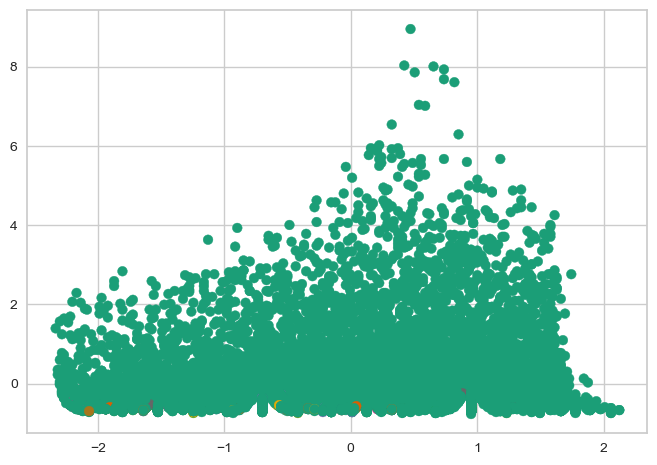

In [64]:
# DBSCAN Checking the best configuration for the data
for eps in [0.2, 0.225, 0.250]:
    for sample in [4,5,6,7]:
        dbscan = DBSCAN(eps=eps, min_samples=sample).fit(X_scaled)
        labels = dbscan.labels_
        plt.scatter(X_scaled[:,0], X_scaled[:,1], c=dbscan.labels_, cmap='Dark2')
        print("eps = ",eps,", sample = ",sample, ", silhoutte_score = ", silhouette_score(X_scaled, labels))
        plt.show()

In [65]:
dbscan_4_4 = DBSCAN(eps=0.2, min_samples=4).fit(X_scaled)
labels_4_4 = dbscan_4_4.labels_

dbscan_4_6 = DBSCAN(eps=0.2, min_samples=6).fit(X_scaled)
labels_4_6 = dbscan_4_6.labels_

dbscan_4_7 = DBSCAN(eps=0.2, min_samples=7).fit(X_scaled)
labels_4_7 = dbscan_4_7.labels_

In [66]:
# Calculate Silhouette Score
silhouette_scores = [silhouette_score(X_scaled, labels_4_4),
                     silhouette_score(X_scaled, labels_4_6),
                     silhouette_score(X_scaled, labels_4_7)]
print("dbscan 4_4= ",silhouette_scores[0])
print("dbscan 4_6= ",silhouette_scores[1])
print("dbscan 4_7= ",silhouette_scores[2])

dbscan 4_4=  -0.5090181788527992
dbscan 4_6=  -0.47174847863804664
dbscan 4_7=  -0.4408061121737822


In [ ]:
# Assigning the labels to new cluster column
df2["cluster"] = labels

Clusters =  4


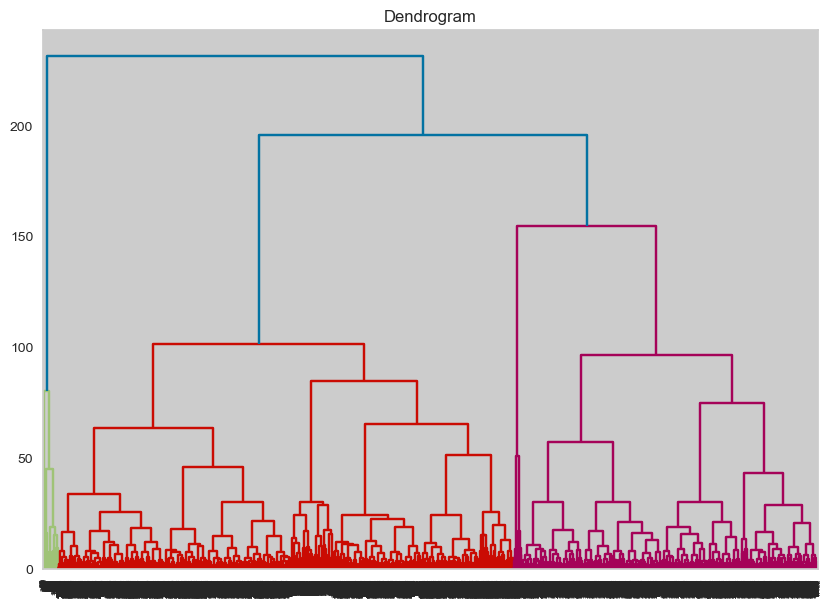

Clusters =  5


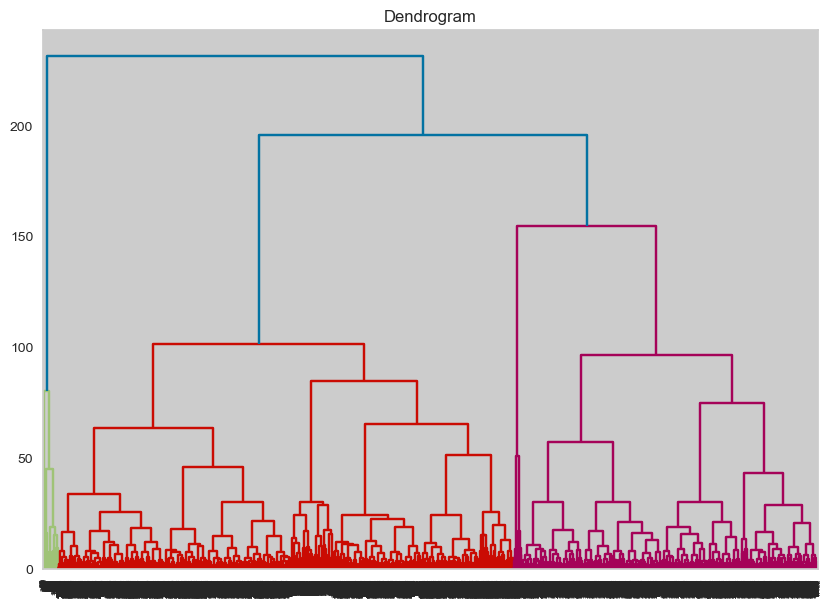

In [35]:
# AgglomerativeClustering
clusters = []
for n in range(4,6):
    # Common method: 'ward' minimizes within-cluster variance
    linked_matrix = linkage(X_scaled, method='ward')
    model = AgglomerativeClustering(n_clusters=n, linkage='ward')
    clusters.append(model.fit_predict(X_scaled))

    plt.figure(figsize=(10, 7))
    dendrogram(linked_matrix)
    plt.title("Dendrogram")
    print("Clusters = ", str(n))
    plt.show()

In [34]:
print(clusters)

[array([3, 3, 3, ..., 0, 0, 0], dtype=int64), array([3, 3, 3, ..., 4, 4, 1], dtype=int64)]


In [13]:
# Assigning the labels to new cluster column
df2['cluster'] = clusters

In [14]:
df2['cluster'].value_counts()

cluster
0    9260
1    6024
3     325
2     149
Name: count, dtype: int64

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

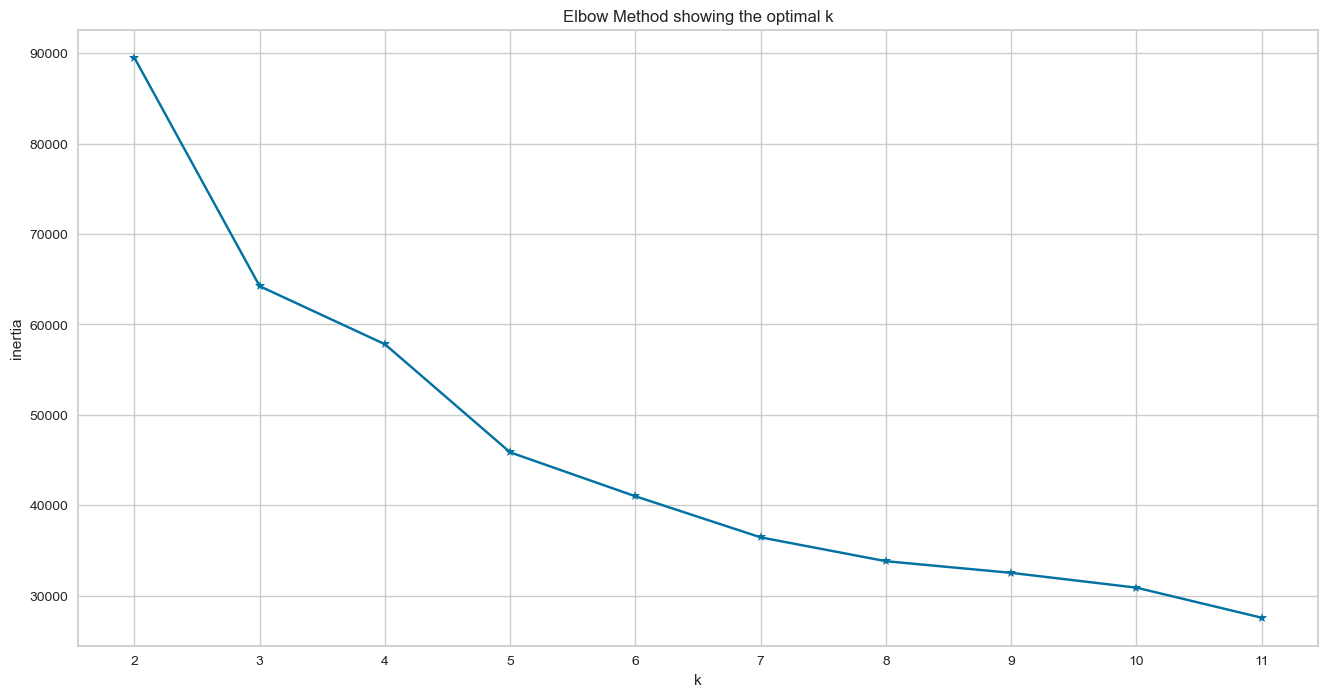

In [21]:
# Using Kmeans as clustering algorithm
K = range(2, 12)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, inertia, marker = '*')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

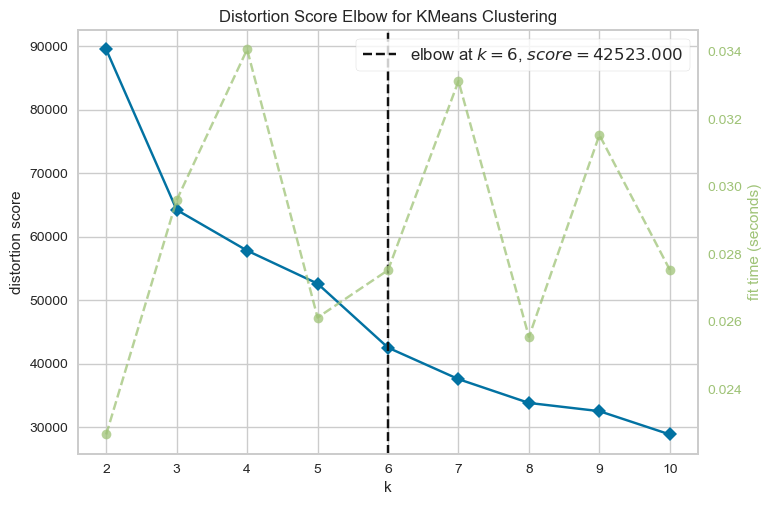

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
# Elbow method
kmeans_visualizer = KElbowVisualizer(KMeans(),K=(2,12))
kmeans_visualizer.fit(X_scaled)
kmeans_visualizer.show()

In [23]:
# Clustering 4:
kmeans4 = KMeans(n_clusters=4, random_state=1234)
kmeans4.fit(X_scaled)
kmeans4.fit_predict(X_scaled)
labels4 = kmeans4.labels_

# Clustering 5:
kmeans5 = KMeans(n_clusters=5, random_state=1234)
kmeans5.fit(X_scaled)
kmeans5.fit_predict(X_scaled)
labels5 = kmeans5.labels_

# Clustering 6:
kmeans6 = KMeans(n_clusters=6, random_state=1234)
kmeans6.fit(X_scaled)
kmeans6.fit_predict(X_scaled)
labels6 = kmeans6.labels_

# Clustering 7:
kmeans7 = KMeans(n_clusters=7, random_state=1234)
kmeans7.fit(X_scaled)
kmeans7.fit_predict(X_scaled)
labels7 = kmeans7.labels_

# Clustering 8:
kmeans8 = KMeans(n_clusters=8, random_state=1234)
kmeans8.fit(X_scaled)
kmeans8.fit_predict(X_scaled)
labels8 = kmeans7.labels_

In [24]:
print([kmeans4.inertia_,kmeans5.inertia_,kmeans6.inertia_,kmeans7.inertia_, kmeans8.inertia_])
min([kmeans4.inertia_,kmeans5.inertia_,kmeans6.inertia_, kmeans7.inertia_, kmeans8.inertia_])

[57813.7048594381, 45850.67263320476, 40991.480636270484, 36446.742136272114, 33809.46774046579]


33809.46774046579

first run
[92579.70348946989, 80986.92914070253, 71338.4073004413, 65576.62415576629]

65576.62415576629
------
after removing "reviews_count"
[85706.03312031488, 75774.95873970508, 66214.27788717014, 60482.143737179846]

60482.143737179846
------
after removing "playtime"
[70042.15968303423, 60260.12145287158, 54528.221714493, 51172.853964116824]

51172.853964116824

The winner for less inertia is cluster=7

In [25]:
print("clusters 4 =",silhouette_score(X_scaled, labels4))
print("clusters 5 =",silhouette_score(X_scaled, labels5))
print("clusters 6 =",silhouette_score(X_scaled, labels6))
print("clusters 7 =",silhouette_score(X_scaled, labels7))
print("clusters 8 =",silhouette_score(X_scaled, labels8))

clusters 4 = 0.2261536574273333
clusters 5 = 0.25215564027979587
clusters 6 = 0.25486808411403156
clusters 7 = 0.2513259765184144
clusters 8 = 0.2513259765184144


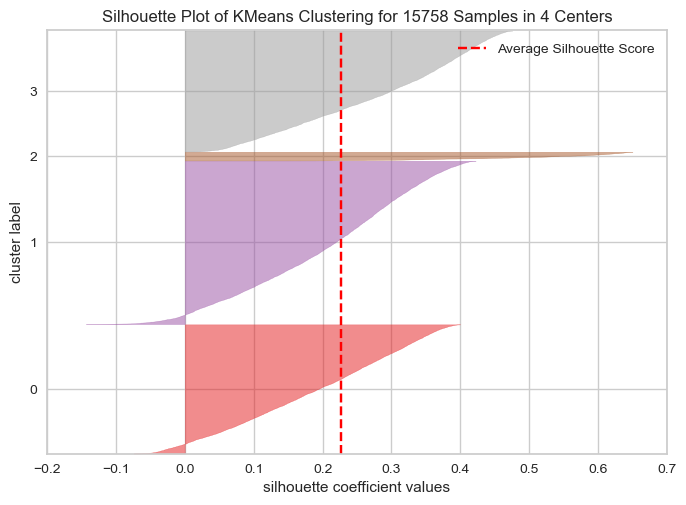

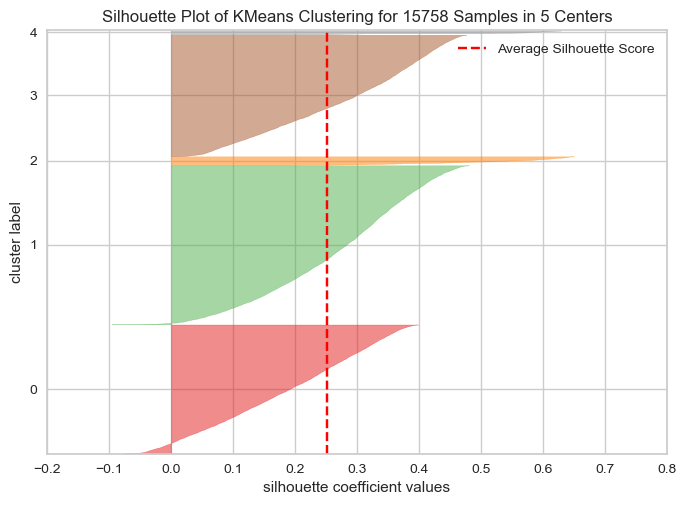

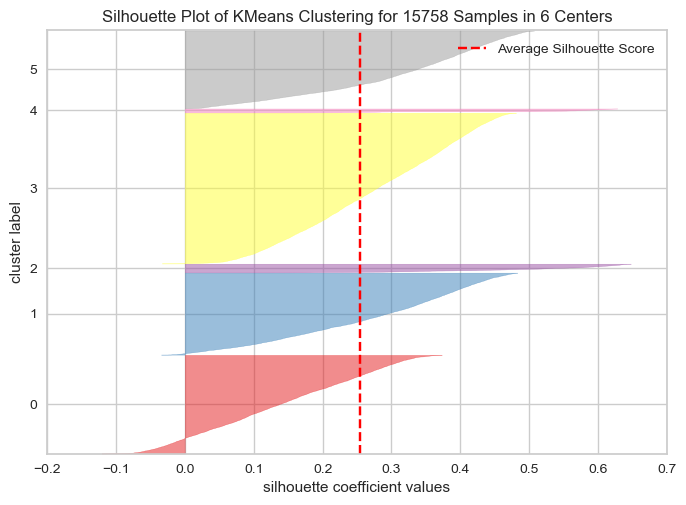

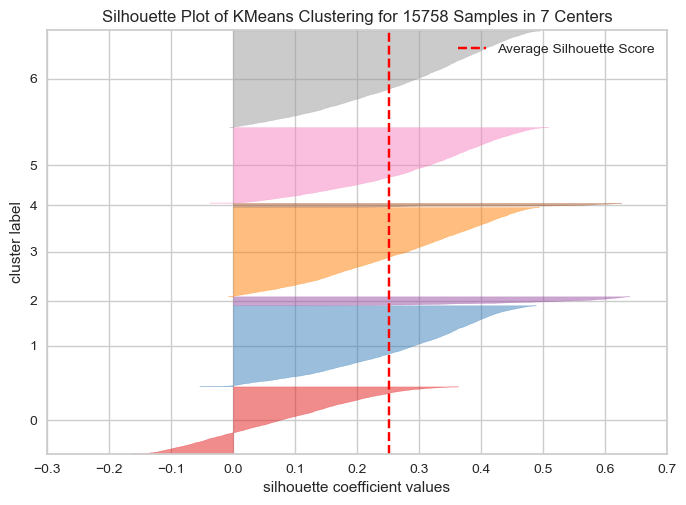

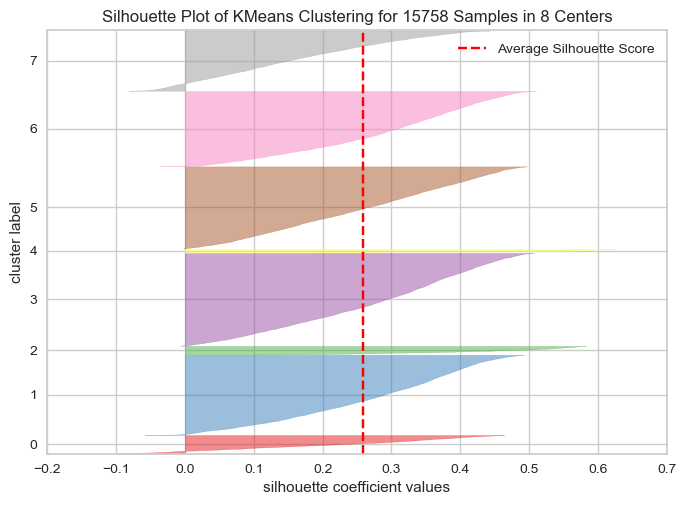

In [26]:
# silhouette visialization
# Loop from 4 to 8 clusters
for n_clusters in range(4, 9):
    sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=n_clusters, random_state=1234))
    sil_visualizer.fit(X_scaled)
    sil_visualizer.show()

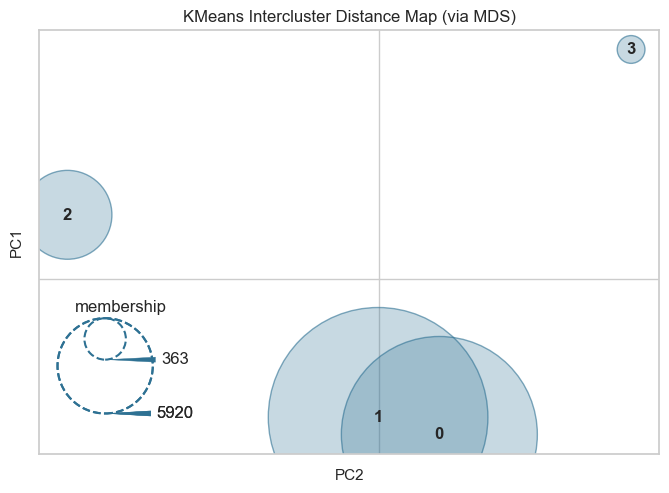

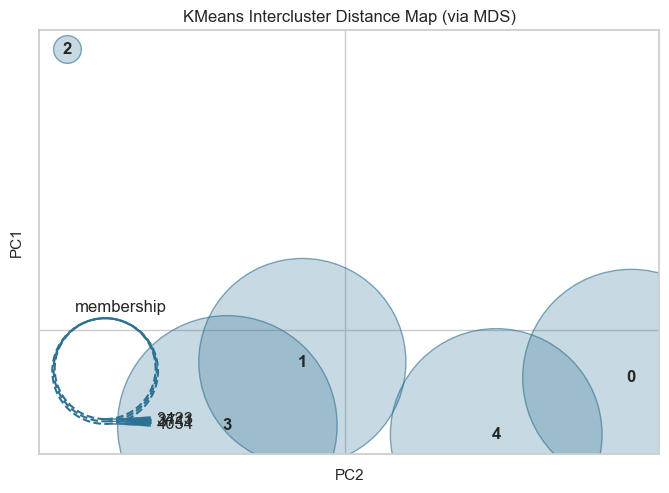

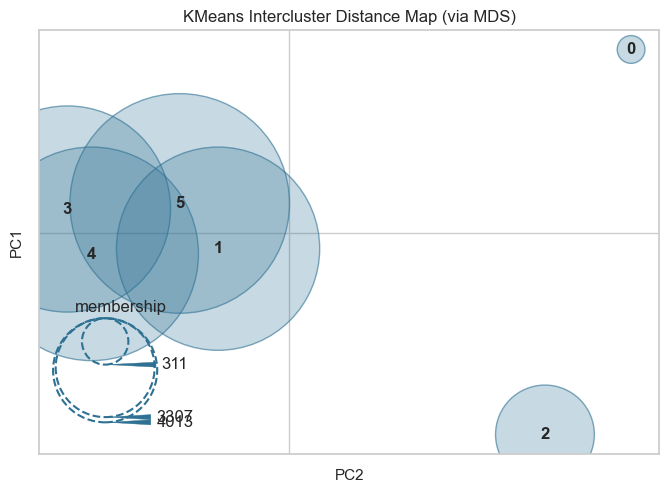

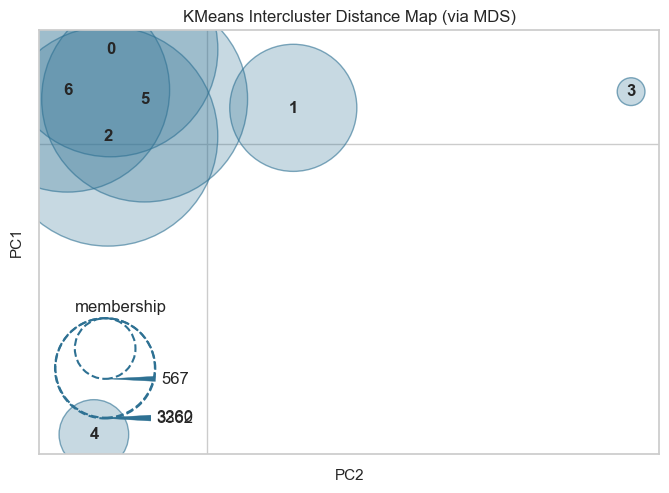

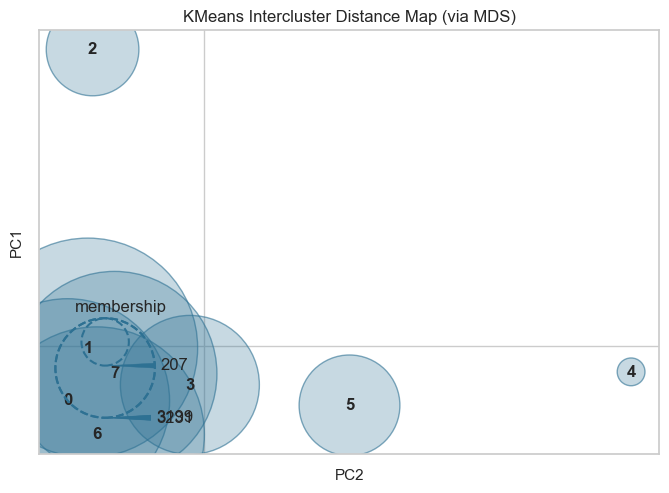

In [35]:
# Intercluster Distance visualization
# Loop from 4 to 8 clusters
for n_clusters in range(4, 9):  
    visualizer = InterclusterDistance(KMeans(n_clusters=n_clusters))  
    visualizer.fit(X_scaled)
    visualizer.show()

In [32]:
# Adding cluster label to dataframes
df2["cluster"] = kmeans7.labels_
numericals["cluster"] = kmeans7.labels_

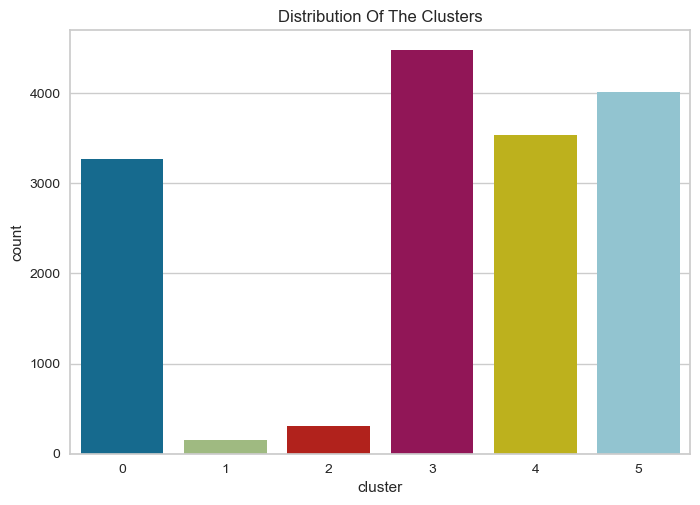

In [41]:
plot = sns.countplot(x=numericals["cluster"])
plot.set_title("Distribution Of The Clusters")
plt.show()

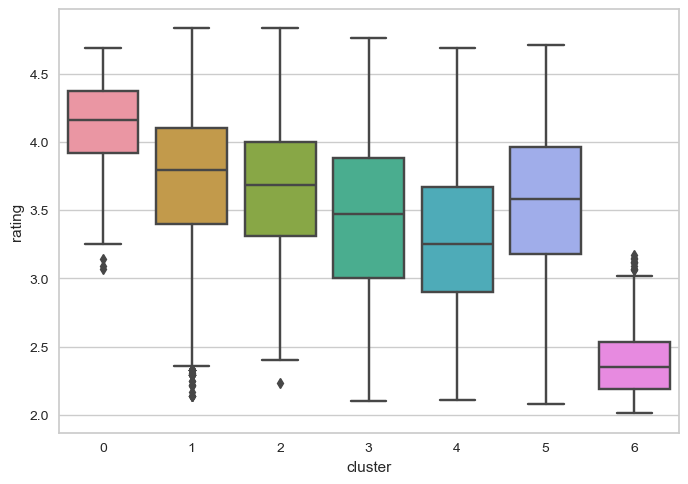

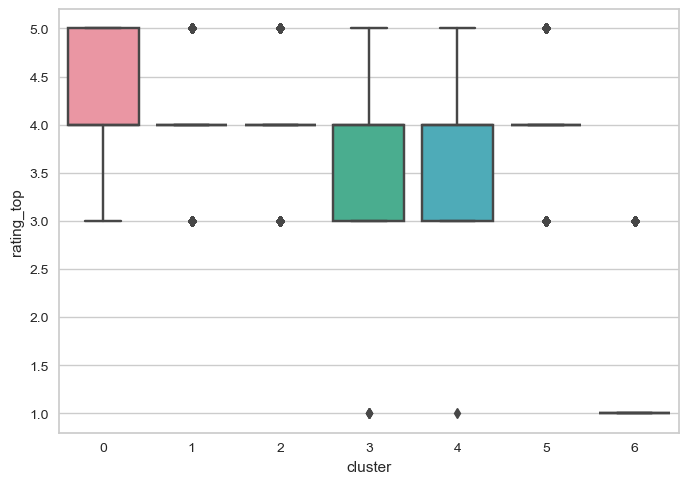

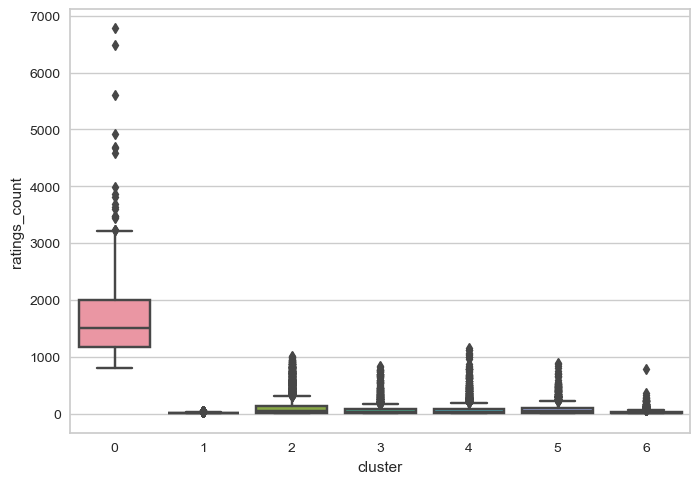

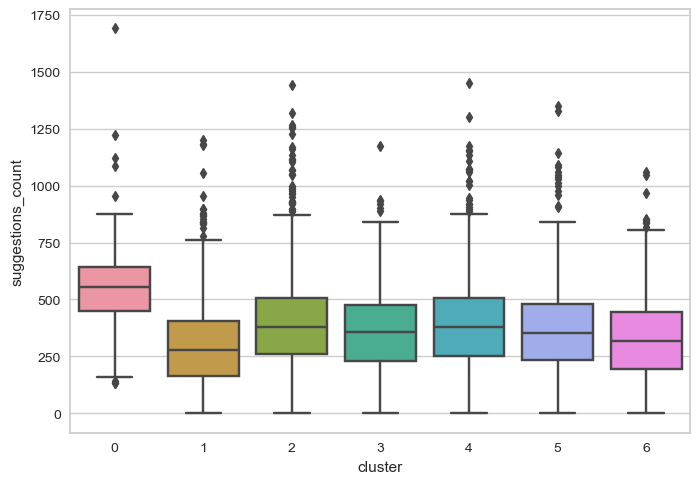

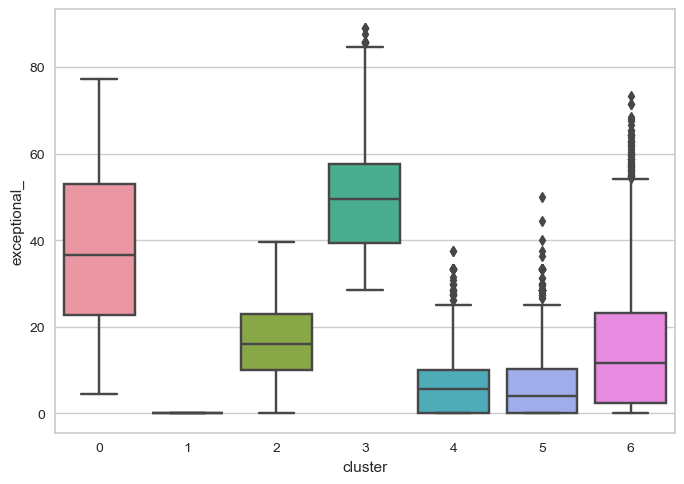

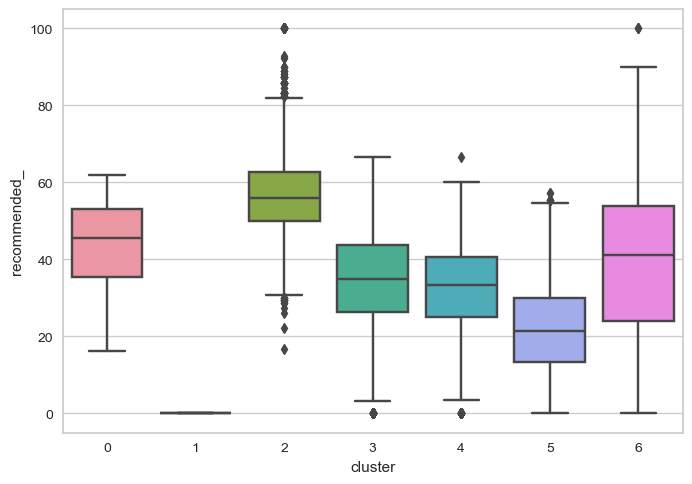

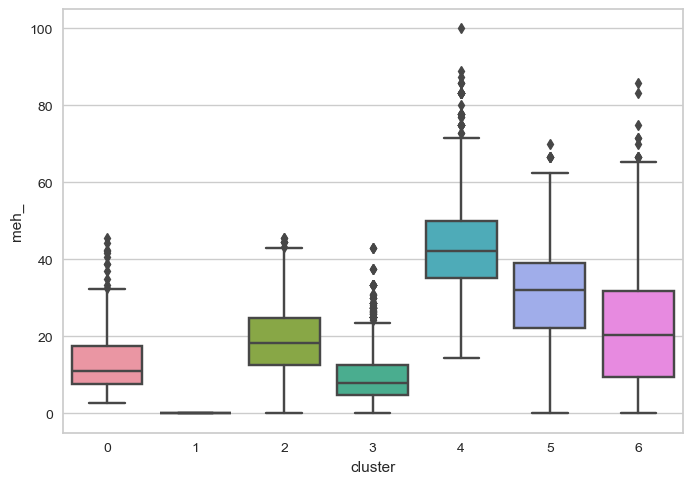

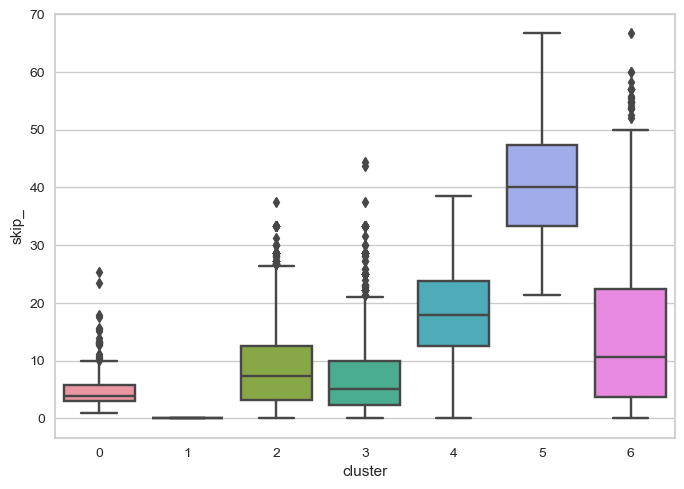

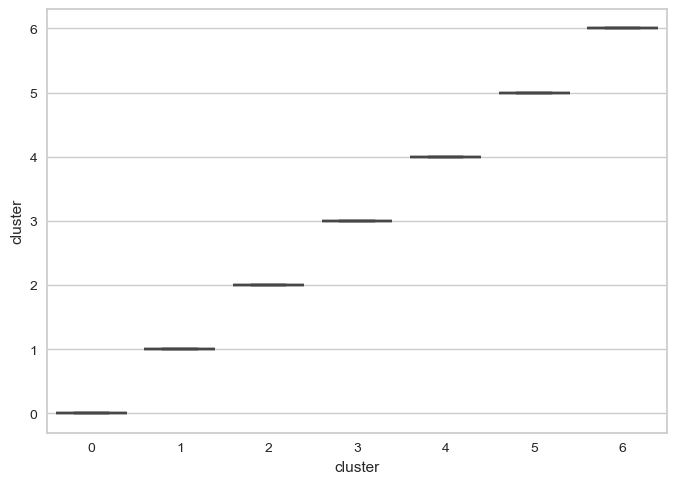

In [31]:
for col in numericals:
    sns.boxplot(x = "cluster", y = col, data=numericals)
    plt.show()

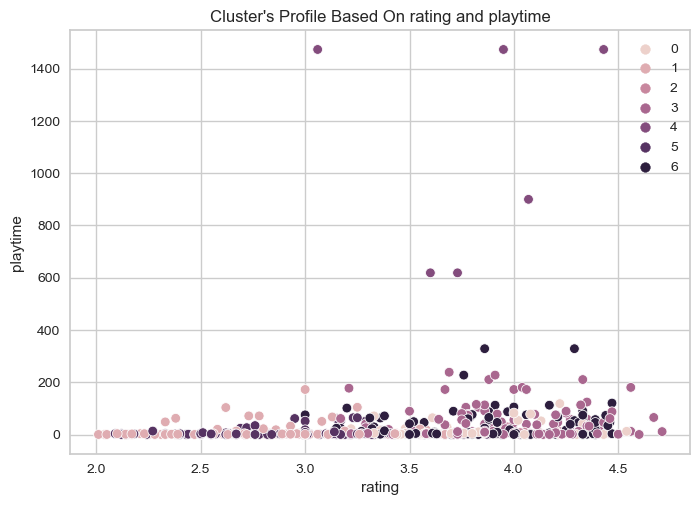

In [33]:
pl = sns.scatterplot(x="rating", y="playtime", hue="cluster", data =numericals.sample(500))
pl.set_title("Cluster's Profile Based On rating and playtime")
plt.legend()
plt.show()

In [33]:
# Export dataframe
df2.to_csv("15759_games_clean_formatted_CLUSTERED.csv")

In [34]:
# Save kmeans model
joblib.dump(kmeans7, "15759_games_kmean7.sav")

['15759_games_kmean7.sav']

In [35]:
# Ranking system implementation for each cluster
df = pd.read_csv("15759_games_clean_formatted_CLUSTERED.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df["released"] = pd.to_datetime(df['released'])

In [36]:
# Ranking
def calculate_ranking_score(df, gravity=1.8):
    """Calculates the ranking score for items in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        gravity (float, optional): Gravity constant. Defaults to 1.8.
    """

    df['ranking_score'] = (df["rating"] - 1) / ((pd.Timestamp.now() - df["released"]).dt.total_seconds() / 3600 + 2) ** gravity
    return df


In [37]:
# Extract every cluster into individual dataframes and calculate the ranking for each cluster invdividually
cluster_df_list = []
for i in range(0,7):
    data = df[df["cluster"] == i]
    data = calculate_ranking_score(data)
    cluster_df_list.append(data)

In [66]:
# Checking clustered dataframes for nans in the ranking column
for df in cluster_df_list:
    # Unique cluster values
    unique_clusters = df["cluster"].unique() 
    print("-------------------------------------------------")
    print(f"Cluster: {unique_clusters[0]}")
    # Columns with NaNs and their counts
    for col in df.columns:
        if col != "background_image":
            nan_count = df[col].isna().sum()  
            if nan_count > 0:
                print(f"Column '{col}': {nan_count} NaN values")
            

-------------------------------------------------
Cluster: 0
-------------------------------------------------
Cluster: 1
-------------------------------------------------
Cluster: 2
Column 'ranking_score': 8 NaN values
-------------------------------------------------
Cluster: 3
-------------------------------------------------
Cluster: 4
Column 'ranking_score': 2 NaN values
-------------------------------------------------
Cluster: 5
Column 'ranking_score': 4 NaN values
-------------------------------------------------
Cluster: 6


In [68]:
# Using SimpleInputer to replace nan values in the ranking_score column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

clusters_to_fill_nan = [cluster_df_list[2], cluster_df_list[4], cluster_df_list[5]]

for cluster in clusters_to_fill_nan:
    cluster['ranking_score'] = imputer.fit_transform(cluster[['ranking_score']])

In [74]:
# For simplicity, assigning each member of the list to a variable
cluster_0_df = cluster_df_list[0]
cluster_1_df = cluster_df_list[1]
cluster_2_df = cluster_df_list[2]
cluster_3_df = cluster_df_list[3]
cluster_4_df = cluster_df_list[4]
cluster_5_df = cluster_df_list[5]
cluster_6_df = cluster_df_list[6]

In [75]:
cluster_2_df.sort_values(by=["ranking_score"], ascending=False)

name   released  \
7089       alone in the dark 2024-03-20   
10730                balatro 2024-02-20   
7294           pacific drive 2024-02-21   
8932           helldivers ii 2024-02-08   
9121            helldivers 2 2024-02-08   
...                      ...        ...   
7623           track & field 1983-01-01   
8624                galaxian 1979-01-01   
9084   space invaders (1978) 1978-06-01   
8020                   joust 1982-07-16   
9836             pong (1972) 1972-11-29   

                                        background_image  rating  rating_top  \
7089   https://media.rawg.io/media/screenshots/719/71...    3.33         3.0   
10730  https://media.rawg.io/media/screenshots/00f/00...    4.48         5.0   
7294   https://media.rawg.io/media/games/43e/43e69395...    3.66         4.0   
8932   https://media.rawg.io/media/games/cbb/cbb94805...    4.36         5.0   
9121   https://media.rawg.io/media/screenshots/d58/d5...    4.00         5.0   
...                                                  ...     ...         ...   
7623   https://media.rawg.io/media/screenshots/302/30...    3.47         4.0   
8624   https://media.rawg.io/media/games/07c/07c5bb43...    3.87         4.0   
9084   https://media.rawg.io/media/screenshots/c38/c3...    3.77         4.0   
8020   https://media.rawg.io/media/screenshots/565/56...    3.03         3.0   
9836   https://media.rawg.io/media/screenshots/c4c/c4...    3.73         4.0   

       ratings_count  playtime  suggestions_count  reviews_count  \
7089            27.0       0.0              393.0           27.0   
10730           19.0       4.0              269.0           21.0   
7294            26.0       6.0              221.0           29.0   
8932            24.0       0.0              302.0           25.0   
9121            14.0       6.0                0.0           15.0   
...              ...       ...                ...            ...   
7623            51.0       0.0              412.0           51.0   
8624            76.0       0.0              180.0           76.0   
9084            69.0       0.0              191.0           69.0   
8020            29.0       0.0              183.0           29.0   
9836            55.0       0.0               11.0           59.0   

         platform_name_0  platform_name_1  platform_name_2 platform_name_3  \
7089       PlayStation 4         Xbox One  Nintendo Switch              PC   
10730           GameCube    PlayStation 2             Xbox              PC   
7294         SEGA Saturn      PlayStation               PC             3DO   
8932       PlayStation 4          Genesis              Wii             iOS   
9121   Commodore / Amiga               PC         Atari ST     SEGA Saturn   
...                  ...              ...              ...             ...   
7623            Xbox One    PlayStation 4               PC       undefined   
8624     Nintendo Switch         Xbox One    PlayStation 4              PC   
9084                  PC              iOS          Android       undefined   
8020                  PC        undefined        undefined       undefined   
9836                  PC  Nintendo Switch         Xbox One       undefined   

          platform_name_4 platform_name_5 platform_name_6     genre_0  \
7089                macOS       undefined       undefined   Adventure   
10730           undefined       undefined       undefined  Simulation   
7294            undefined       undefined       undefined      Racing   
8932            undefined       undefined       undefined      Action   
9121   SEGA Master System    Nintendo 3DS       Game Gear      Racing   
...                   ...             ...             ...         ...   
7623            undefined       undefined       undefined         RPG   
8624            undefined       undefined       undefined      Action   
9084            undefined       undefined       undefined      Action   
8020            undefined       undefined       undefined     

In [76]:
combined_df = pd.concat([cluster_0_df,cluster_1_df,cluster_2_df,cluster_3_df,cluster_4_df,cluster_5_df,cluster_6_df])
combined_df

name   released  \
0                        grand theft auto v 2013-09-17   
1                  the witcher 3: wild hunt 2015-05-18   
2                                  portal 2 2011-04-18   
3          counter-strike: global offensive 2012-08-21   
4                        tomb raider (2013) 2013-03-05   
...                                     ...        ...   
15668               bus simulator: ultimate 2019-06-13   
15683   world war ii combat: road to berlin 2006-01-23   
15708  syberia 3 - an automaton with a plan 2017-11-07   
15734                             fatalzone 2023-10-23   
15749                 rise of civilizations 2018-06-09   

                                        background_image  rating  rating_top  \
0      https://media.rawg.io/media/games/20a/20aa03a1...    4.47         5.0   
1      https://media.rawg.io/media/games/618/618c2031...    4.65         5.0   
2      https://media.rawg.io/media/games/2ba/2bac0e87...    4.61         5.0   
3      https://media.rawg.io/media/games/736/73619bd3...    3.57         4.0   
4      https://media.rawg.io/media/games/021/021c4e21...    4.05         4.0   
...                                                  ...     ...         ...   
15668  https://media.rawg.io/media/screenshots/5a5/5a...    2.67         1.0   
15683  https://media.rawg.io/media/screenshots/927/92...    2.33         1.0   
15708  https://media.rawg.io/media/screenshots/987/98...    2.29         1.0   
15734  https://media.rawg.io/media/screenshots/ed7/ed...    2.33         1.0   
15749  https://media.rawg.io/media/screenshots/e6b/e6...    2.50         1.0   

       ratings_count  playtime  suggestions_count  reviews_count  \
0             6777.0      74.0              431.0         6878.0   
1             6489.0      45.0              675.0         6595.0   
2             5615.0      11.0              550.0         5668.0   
3             3443.0      65.0              587.0         3478.0   
4             3863.0      10.0              646.0         3892.0   
...              ...       ...                ...            ...   
15668            7.0       0.0              225.0            9.0   
15683            6.0       0.0              429.0            6.0   
15708            7.0       0.0              274.0            7.0   
15734            5.0       0.0              475.0            6.0   
15749            6.0       0.0              181.0            6.0   

       platform_name_0 platform_name_1  platform_name_2 platform_name_3  \
0                   PC   PlayStation 5  Xbox Series S/X   PlayStation 4   
1      Xbox Series S/X   PlayStation 5            macOS   PlayStation 4   
2        PlayStation 3              PC         Xbox 360           Linux   
3                   PC           Linux         Xbox 360   PlayStation 3   
4        PlayStation 4           macOS               PC        Xbox One   
...                ...             ...              ...             ...   
15668        undefined       undefined        undefined       undefined   
15683        undefined       undefined        undefined       undefined   
15708        undefined       undefined        undefined       undefined   
15734        undefined       undefined        undefined       undefined   
15749        undefined       undefined        undefined       undefined   

       platform_name_4 platform_name_5 platform_name_6    genre_0    genre_1  \
0        PlayStation 3        Xbox 360        Xbox One     Action  undefined   
1      Nintendo Switch              PC        Xbox One     Action        RPG   
2                macOS        Xbox One       undefined    Shooter     Puzzle   
3            undefined       undefined       undefined    Shooter  undefined   
4             Xbox 360   PlayStation 3       undefined     Action  undefined   
...                ...             ...             ...        ...        ...   
15668        undefined       undefined       undefined  undefined  undefined   
15683        undefined 

In [77]:
combined_df.isna().sum()

name                  0
released              0
background_image     64
rating                0
rating_top            0
ratings_count         0
playtime              0
suggestions_count     0
reviews_count         0
platform_name_0       0
platform_name_1       0
platform_name_2       0
platform_name_3       0
platform_name_4       0
platform_name_5       0
platform_name_6       0
genre_0               0
genre_1               0
tags_extracted        0
exceptional_          0
recommended_          0
meh_                  0
skip_                 0
cluster               0
ranking_score         0
dtype: int64

In [32]:
# Export dataframe clustered and each cluster ranked
combined_df.to_csv("15759_games_clean_formatted_CLUSTERED_RANKED.csv")

# combined_df = pd.read_csv("15759_games_clean_formatted_CLUSTERED_RANKED.csv")
# combined_df.drop(["Unnamed: 0"], axis=1, inplace=True, errors="ignore")

In [5]:
from scipy import stats

# ANOVA
# Conduct a one-way ANOVA test for each feature. This compares mean values between the cluster groups.
numericals = combined_df.select_dtypes(include='number')
for col in numericals.columns:
    f_val, p_val = stats.f_oneway(*[combined_df[combined_df["cluster"] == c][col] for c in combined_df["cluster"].unique()])  
    print(f"{col}: F-value = {f_val:.3f}, p-value = {p_val:.4f}")

rating: F-value = 1752.892, p-value = 0.0000
rating_top: F-value = 4517.600, p-value = 0.0000
ratings_count: F-value = 5406.411, p-value = 0.0000
playtime: F-value = 17.780, p-value = 0.0000
suggestions_count: F-value = 202.085, p-value = 0.0000
reviews_count: F-value = 5399.614, p-value = 0.0000
exceptional_: F-value = 7079.520, p-value = 0.0000
recommended_: F-value = 9265.831, p-value = 0.0000
meh_: F-value = 6632.081, p-value = 0.0000
skip_: F-value = 7150.269, p-value = 0.0000
cluster: F-value = inf, p-value = 0.0000
ranking_score: F-value = 0.324, p-value = 0.9246


In [9]:
# Intra-Cluster Statistics
numericals.groupby("cluster").agg(["mean", "median"])

rating        rating_top        ratings_count           playtime  \
             mean median       mean median          mean  median       mean   
cluster                                                                       
0        4.108831   4.16   4.409231    4.0   1742.360000  1515.0  10.421538   
1        3.719710   3.79   4.067698    4.0     12.118203     9.0   2.029443   
2        3.649576   3.68   4.012686    4.0    126.259649    48.0   4.232659   
3        3.451259   3.47   3.837960    4.0     76.111039    30.0   3.464816   
4        3.295070   3.25   3.688596    4.0     83.708333    35.0   3.171930   
5        3.566724   3.58   3.979346    4.0     84.183592    44.0   4.589788   
6        2.383513   2.35   1.330007    1.0     29.890885    16.0   2.075848   

               suggestions_count        reviews_count         exceptional_  \
        median              mean median          mean  median         mean   
cluster                                                                      
0          7.0        536.664615  555.0   1761.898462  1537.0    37.489631   
1          0.0        293.042768  279.0     12.408554    10.0     0.000000   
2          2.0        386.755466  380.0    127.828610    49.0    16.341223   
3          2.0        357.922531  359.0     77.103292    30.0    49.763066   
4          2.0        383.600000  380.0     84.659211    36.0     6.651417   
5          2.0        363.181870  354.0     85.314974    45.0     6.365491   
6          1.0        325.526946  319.0     30.129075    16.0    15.522488   

               recommended_              meh_             skip_          \
        median         mean median       mean median       mean  median   
cluster                                                                   
0        36.50    43.757415  45.46  13.819569  11.16   4.933692   3.950   
1         0.00     0.000000   0.00   0.000000   0.00   0.000000   0.000   
2        15.96    56.812100  56.00  18.300335  18.18   8.546329   7.350   
3        49.62    34.086850  34.86   9.203880   7.91   6.945862   5.130   
4         5.56    31.992189  33.33  43.431671  42.26  17.924649  17.945   
5         4.08    21.963098  21.30  30.791067  32.14  40.879713  40.000   
6        11.76    37.903387  41.18  21.519142  20.34  14.808297  10.640   

        ranking_score                
                 mean        median  
cluster                              
0        6.194475e-09  3.878270e-09  
1        3.314760e-08  1.635546e-09  
2        3.153884e-08  3.629312e-09  
3        3.276197e-08  3.416081e-09  
4        2.446263e-08  3.296915e-09  
5        3.710086e-08  3.655456e-09  
6        2.903290e-08  2.232627e-09

In [11]:
numericals.groupby("cluster").std()

rating  rating_top  ratings_count   playtime  suggestions_count  \
cluster                                                                      
0        0.306003    0.528719     854.628449  12.646579         167.837999   
1        0.493426    0.608706       7.467715  24.573337         165.531021   
2        0.470663    0.549495     183.190400  12.358109         175.673249   
3        0.548529    0.608047     123.232116   9.259374         164.712467   
4        0.508668    0.573246     133.658336   6.790819         177.651874   
5        0.525375    0.581605     108.975943  25.338350         171.302512   
6        0.226766    0.742614      42.816551   2.235078         168.331292   

         reviews_count  exceptional_  recommended_       meh_      skip_  \
cluster                                                                    
0           866.018236     17.652900     11.147506   8.425275   3.211310   
1             7.591323      0.000000      0.000000   0.000000   0.000000   
2           185.064134      9.148079     11.075011   9.044686   6.877558   
3           124.765008     12.571100     13.740547   7.163356   6.736061   
4           134.731163      6.461639     11.947467  11.718123   8.510457   
5           110.210830      7.581369     11.915091  12.233235   8.923323   
6            42.982787     15.695473     20.870915  15.648063  14.013262   

         ranking_score  
cluster                 
0         8.518621e-09  
1         3.672536e-07  
2         3.598318e-07  
3         3.294142e-07  
4         2.812791e-07  
5         5.965233e-07  
6         8.658306e-07

In [13]:
numericals[numericals["cluster"] == 1]

rating  rating_top  ratings_count  playtime  suggestions_count  \
325     3.00         3.0            6.0       0.0              572.0   
326     3.22         4.0            9.0       0.0              348.0   
327     3.98         4.0           39.0       1.0              150.0   
328     4.00         4.0            6.0       4.0              268.0   
329     3.33         4.0            6.0       2.0              281.0   
...      ...         ...            ...       ...                ...   
4973    3.83         4.0            5.0       0.0              374.0   
4974    4.43         5.0            7.0       0.0               19.0   
4975    4.11         4.0            7.0       0.0              111.0   
4976    4.33         5.0            6.0       0.0              216.0   
4977    4.33         5.0            4.0       0.0              236.0   

      reviews_count  exceptional_  recommended_  meh_  skip_  cluster  \
325             6.0           0.0           0.0   0.0    0.0        1   
326             9.0           0.0           0.0   0.0    0.0        1   
327            40.0           0.0           0.0   0.0    0.0        1   
328             6.0           0.0           0.0   0.0    0.0        1   
329             6.0           0.0           0.0   0.0    0.0        1   
...             ...           ...           ...   ...    ...      ...   
4973            6.0           0.0           0.0   0.0    0.0        1   
4974            7.0           0.0           0.0   0.0    0.0        1   
4975            9.0           0.0           0.0   0.0    0.0        1   
4976            6.0           0.0           0.0   0.0    0.0        1   
4977            6.0           0.0           0.0   0.0    0.0        1   

      ranking_score  
325    1.338711e-09  
326    1.480847e-09  
327    3.357261e-10  
328    5.782618e-09  
329    3.747821e-09  
...             ...  
4973   1.826509e-08  
4974   1.806120e-08  
4975   1.297012e-08  
4976   9.071941e-09  
4977   2.235540e-08  

[4653 rows x 12 columns]

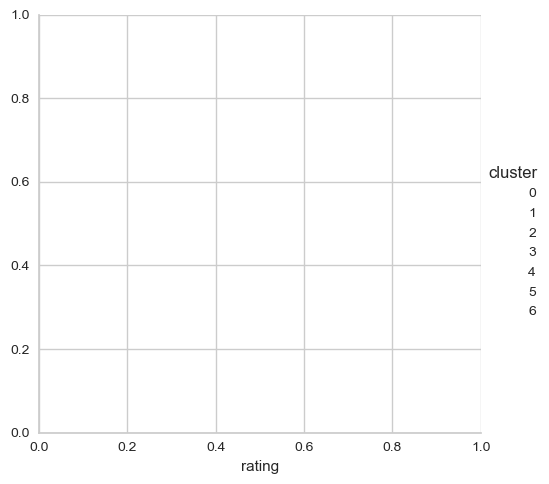

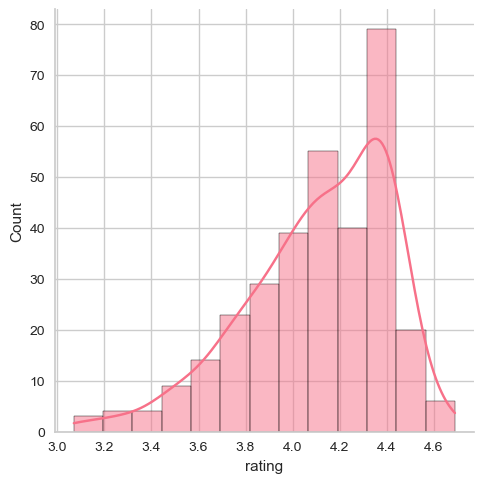

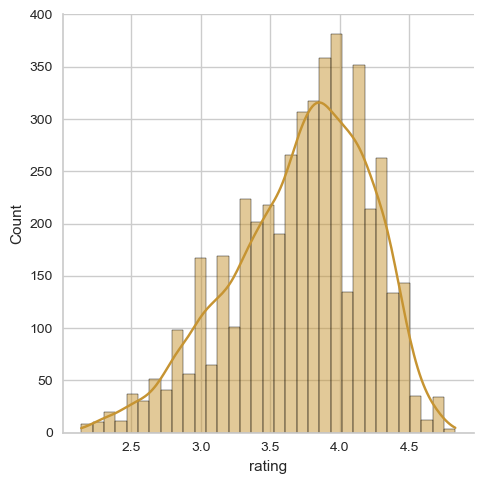

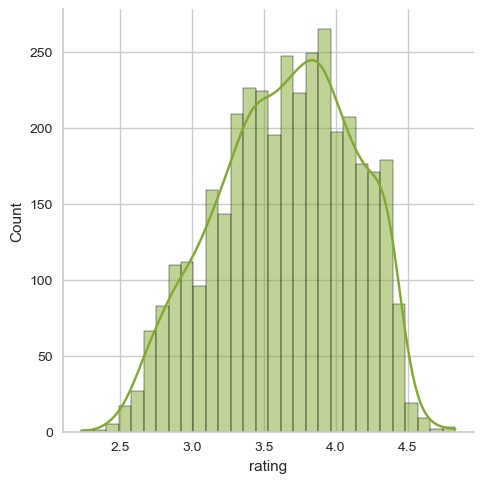

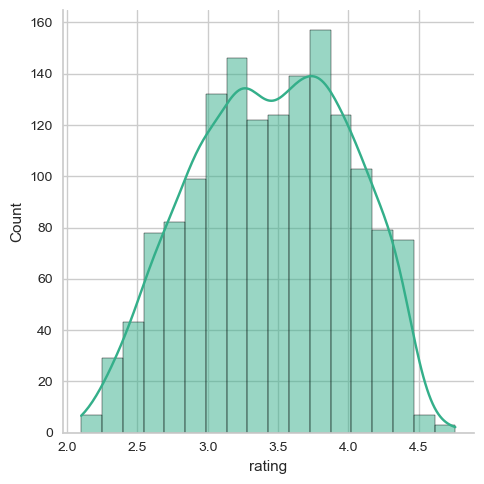

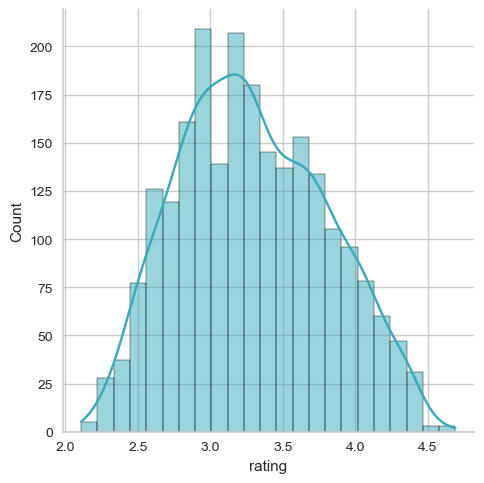

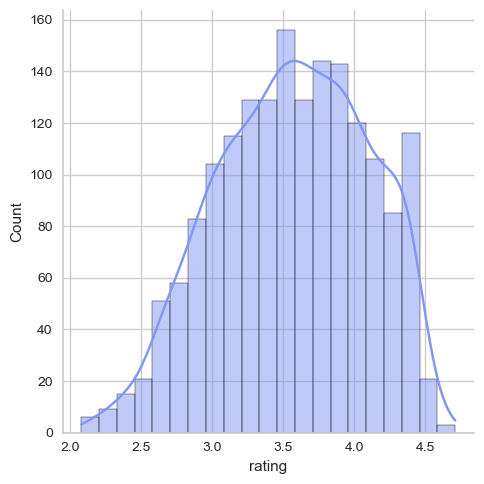

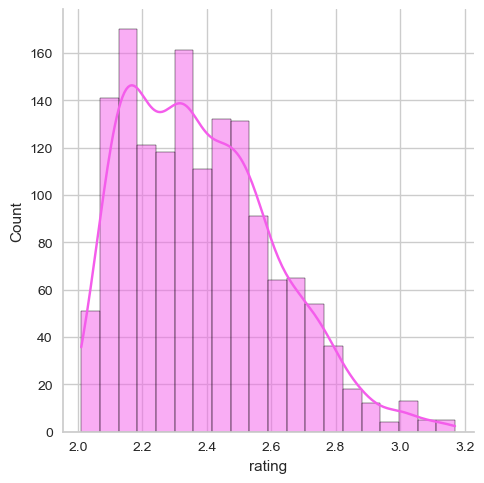

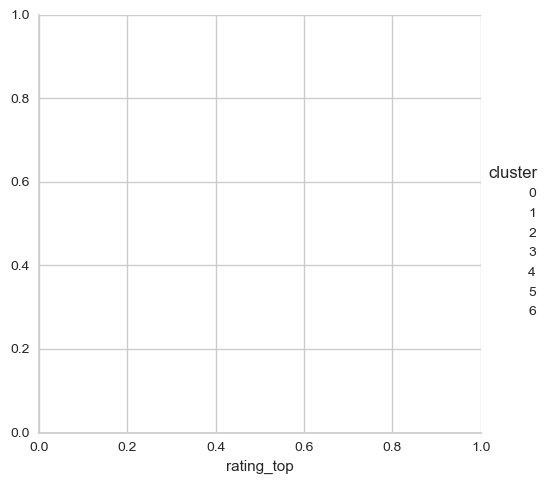

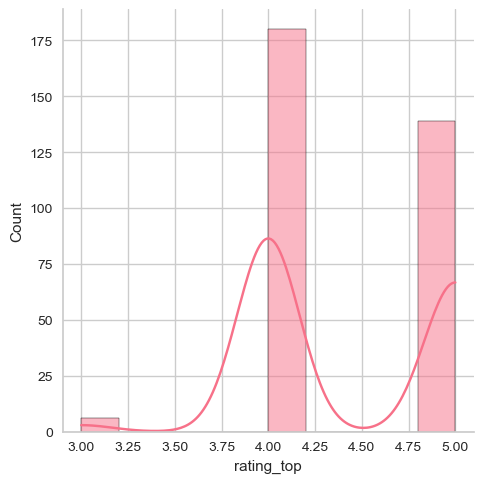

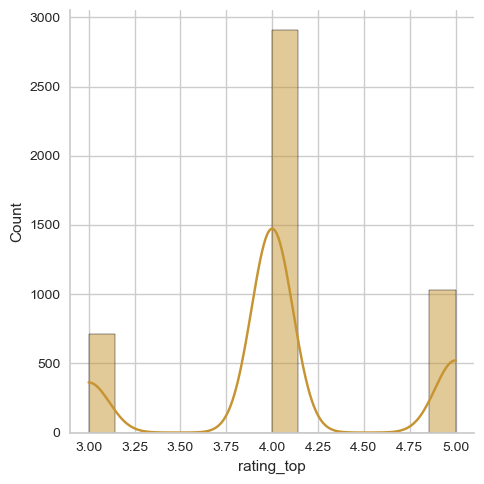

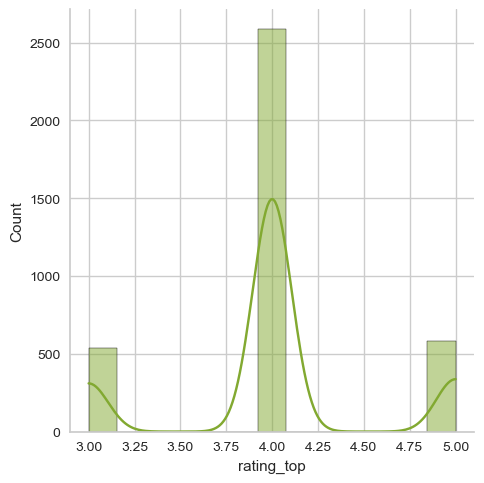

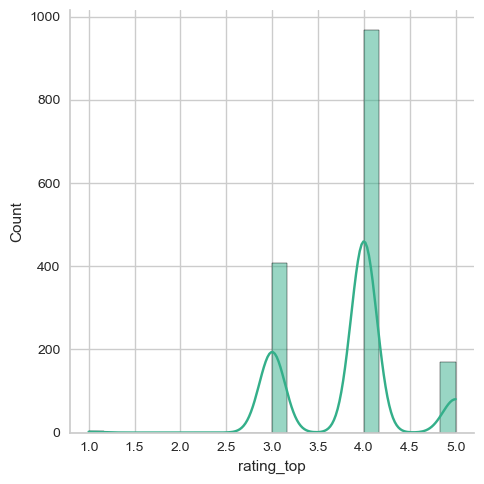

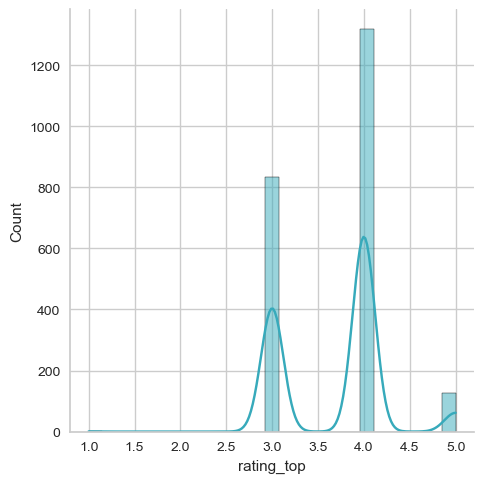

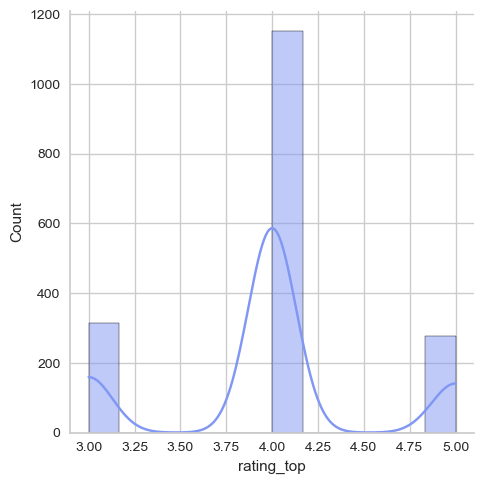

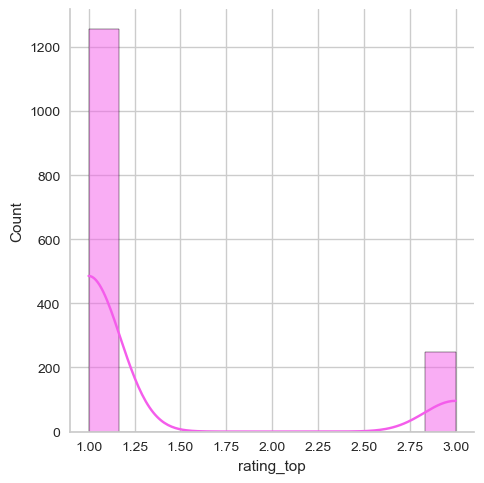

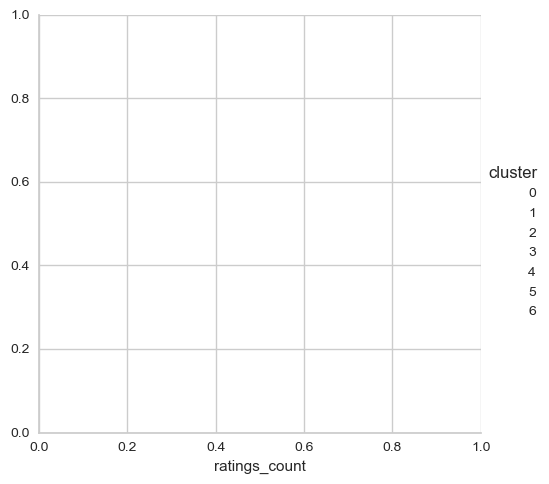

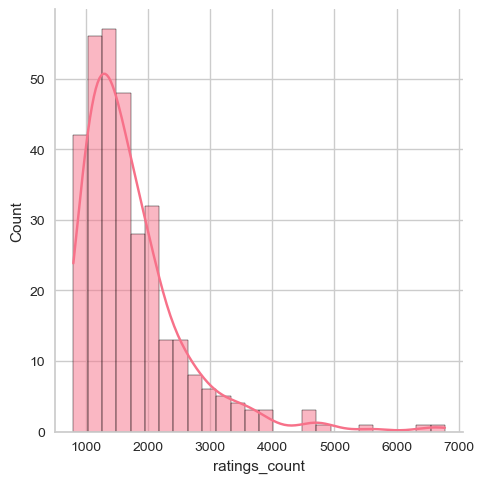

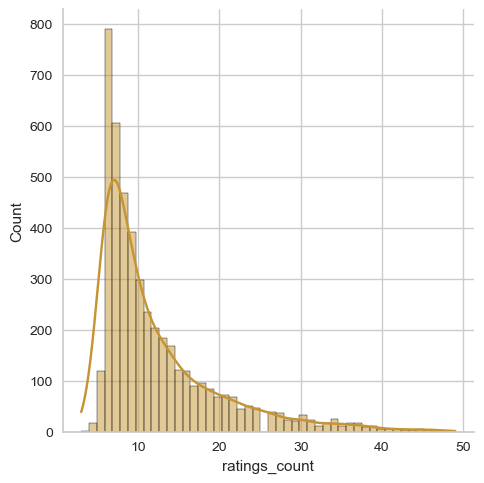

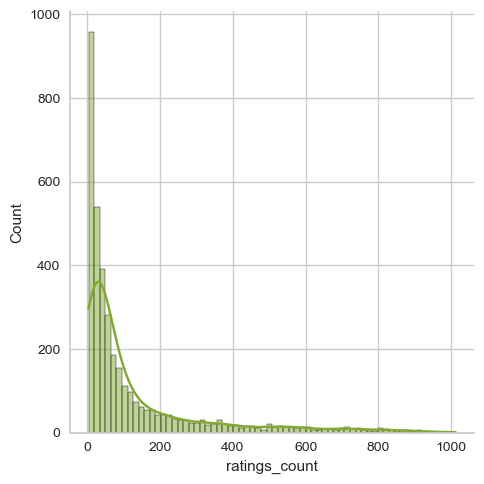

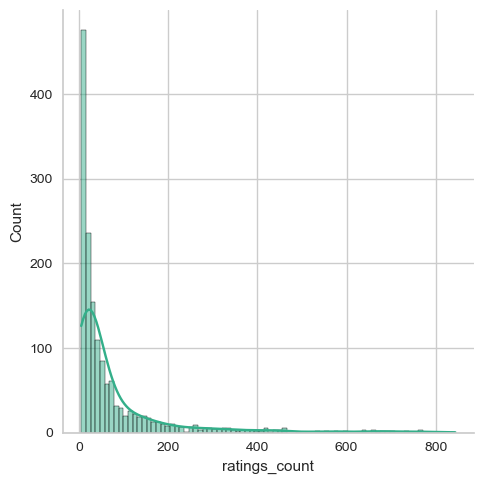

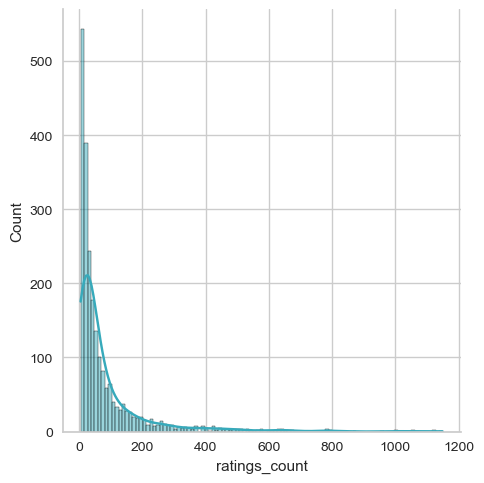

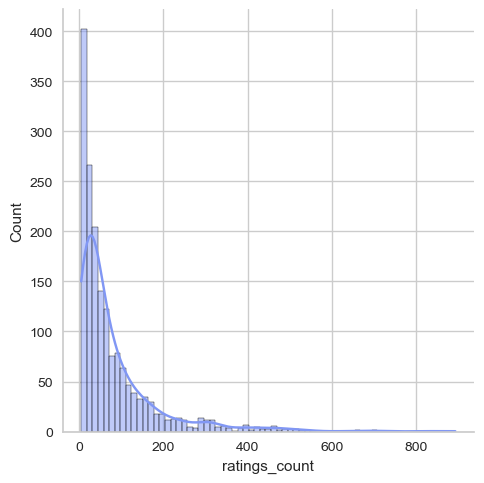

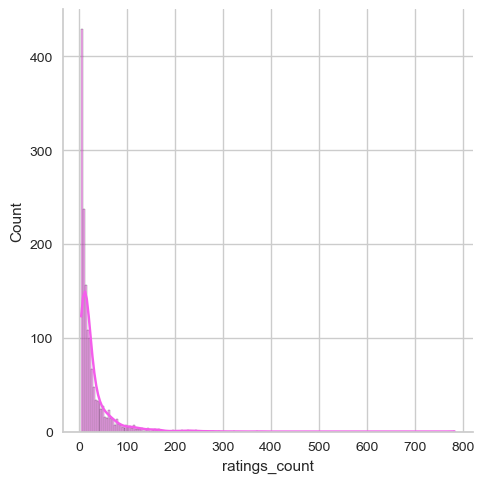

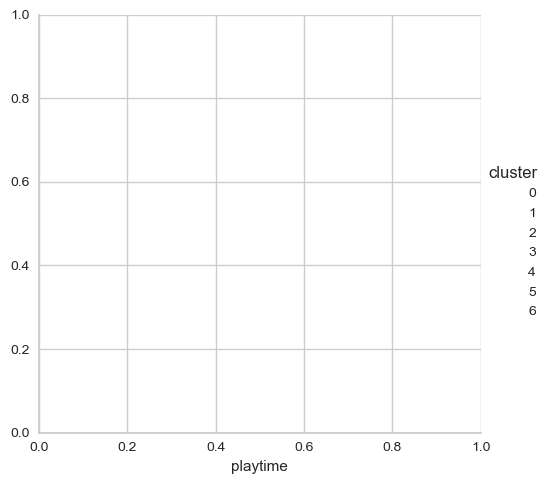

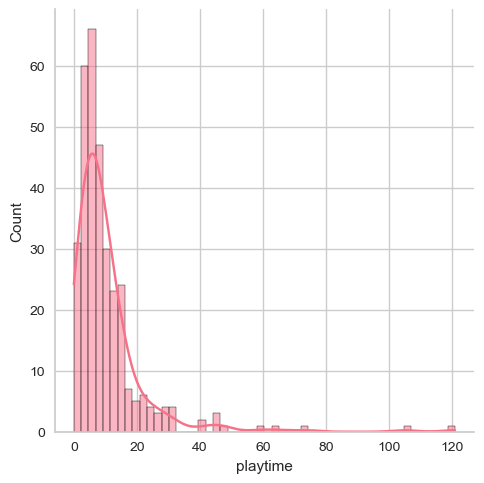

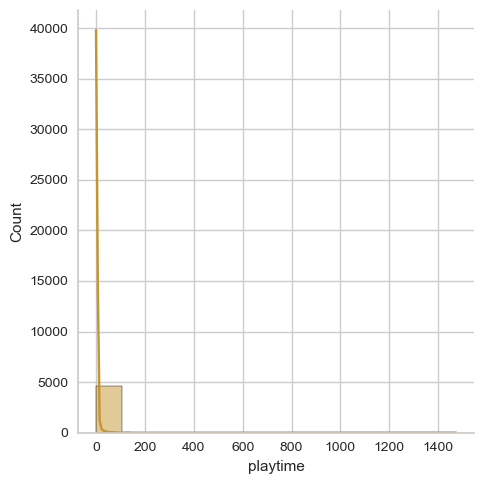

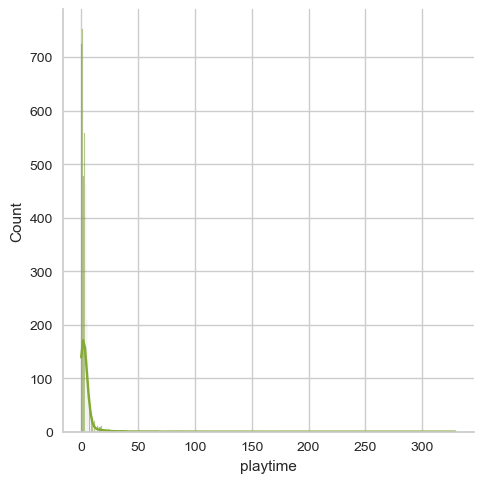

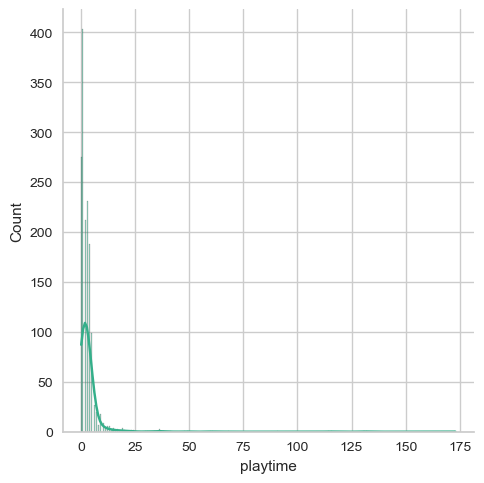

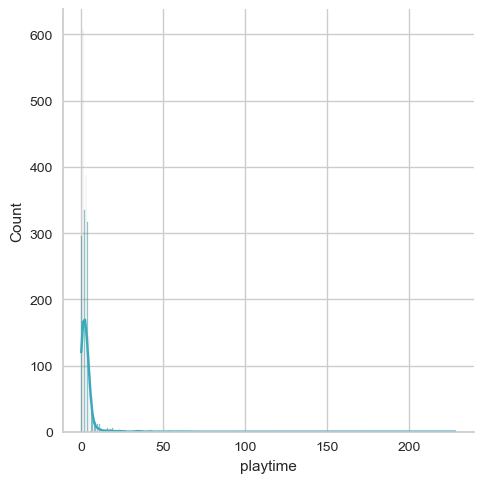

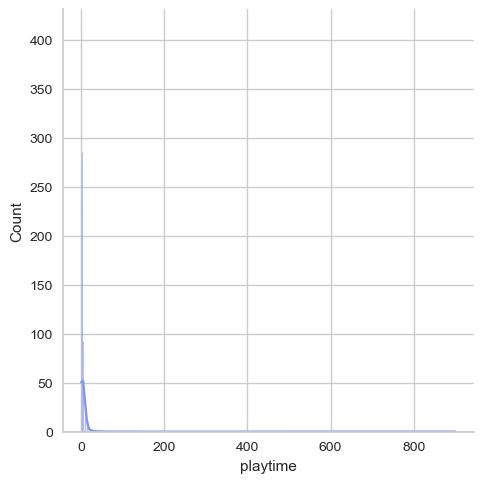

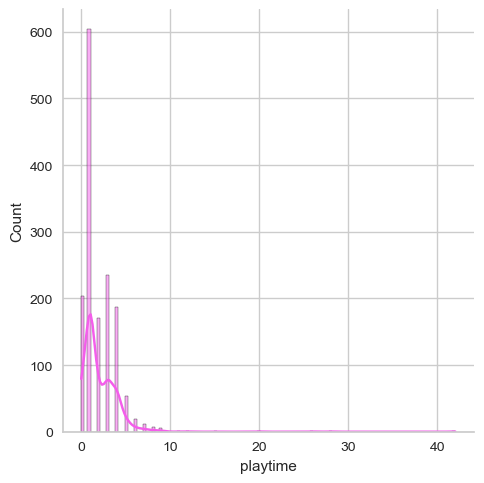

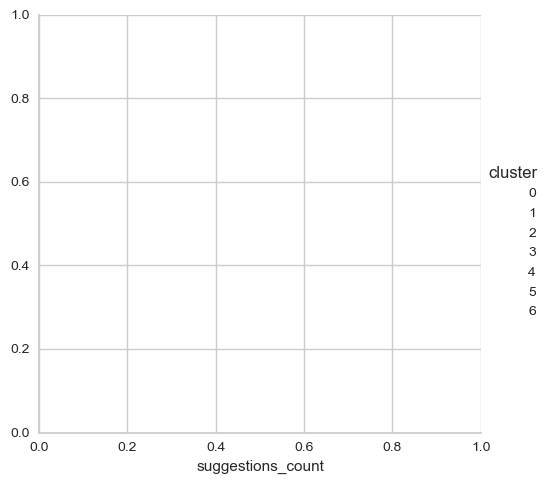

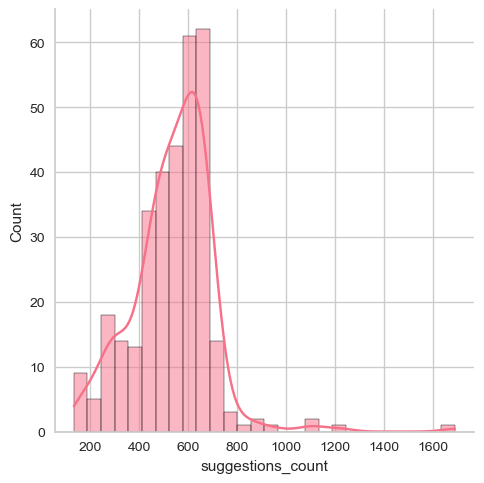

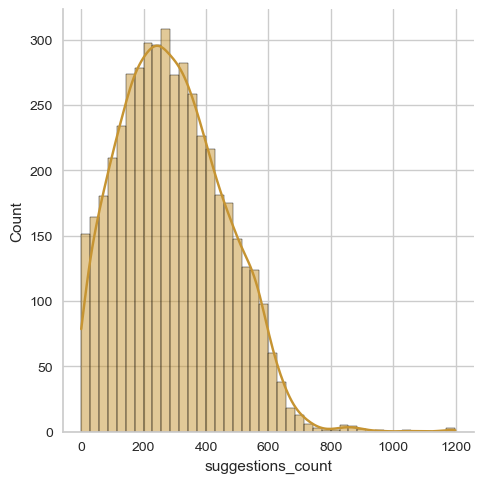

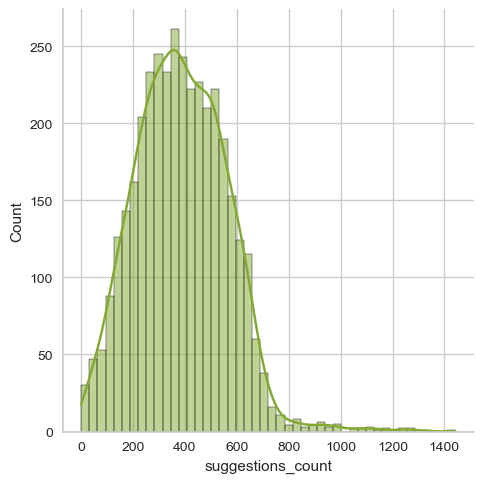

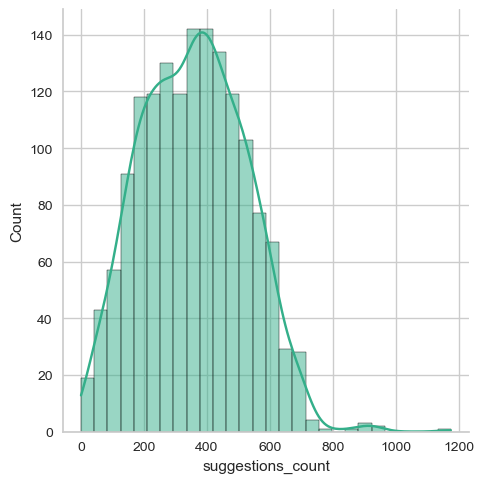

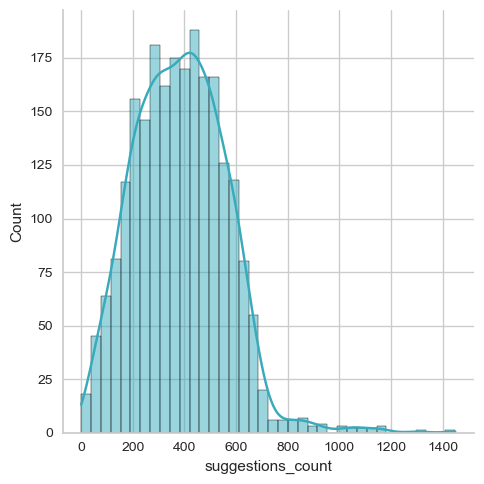

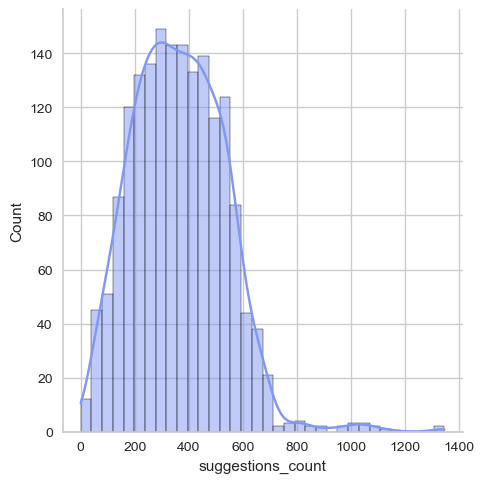

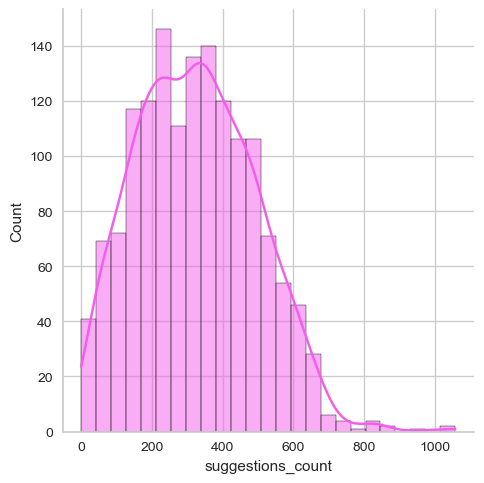

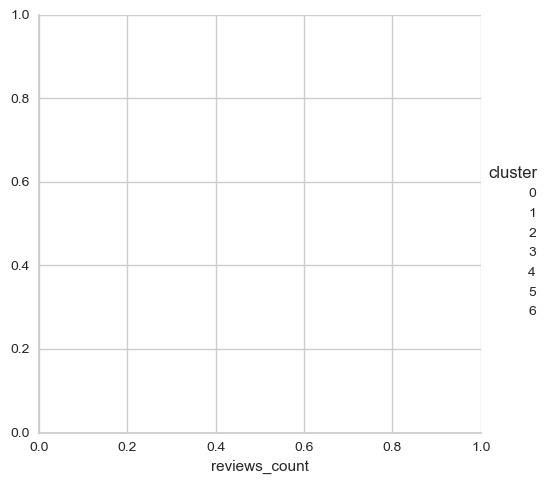

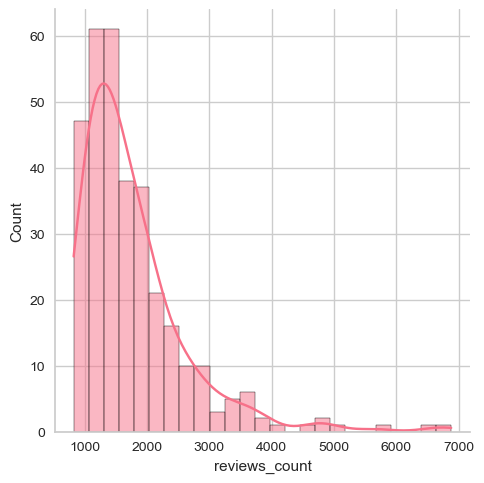

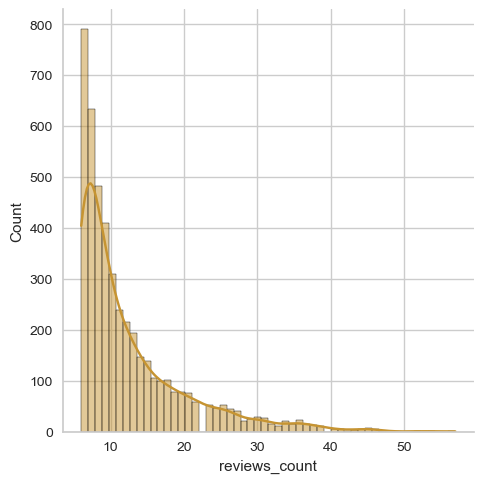

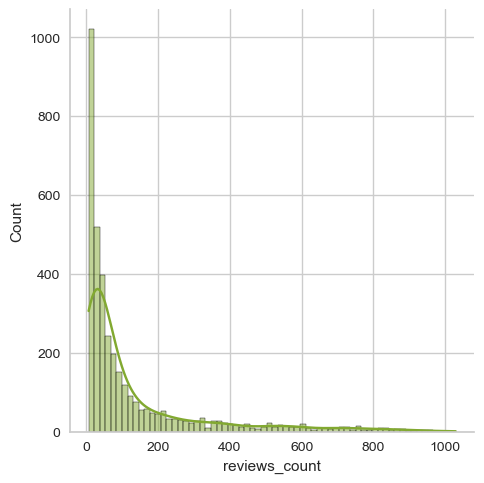

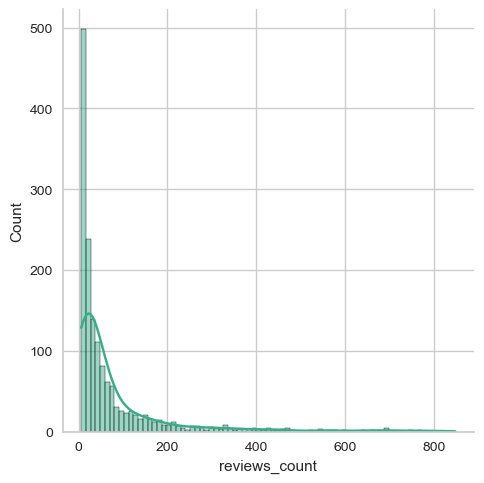

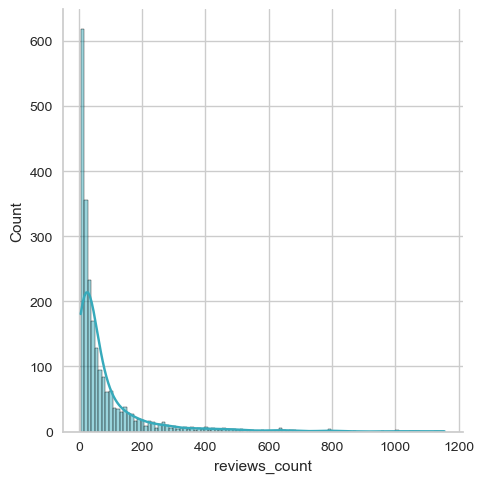

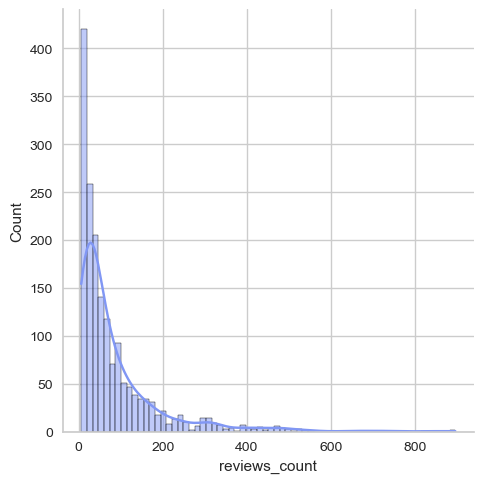

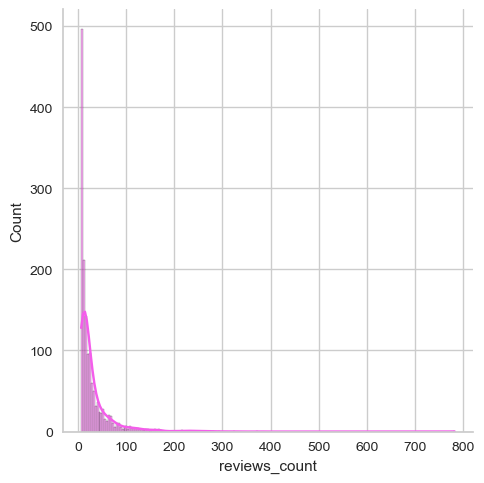

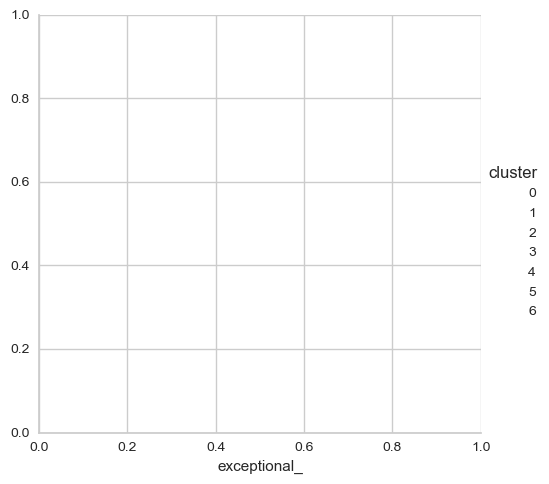

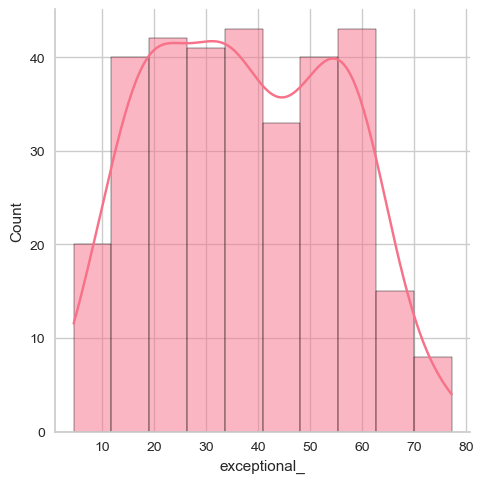

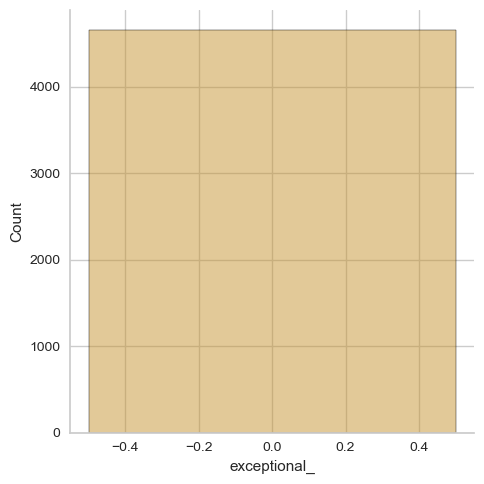

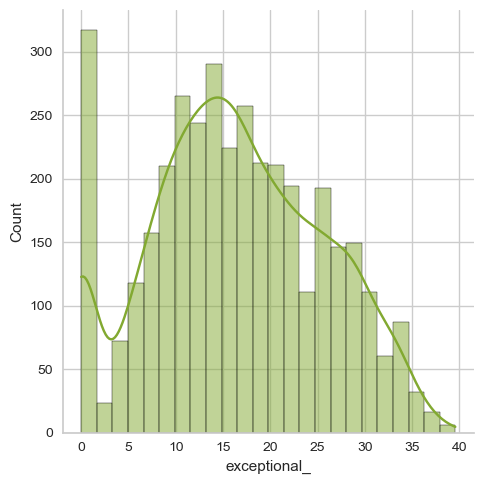

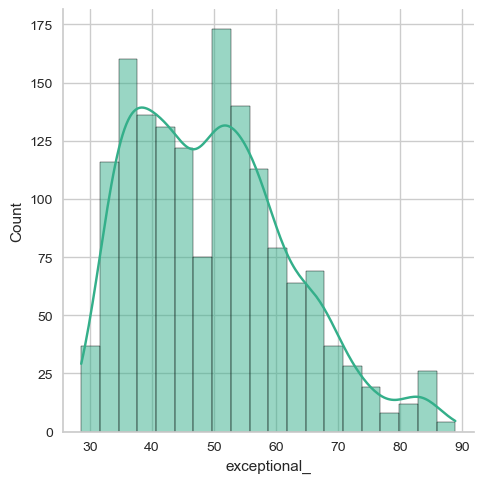

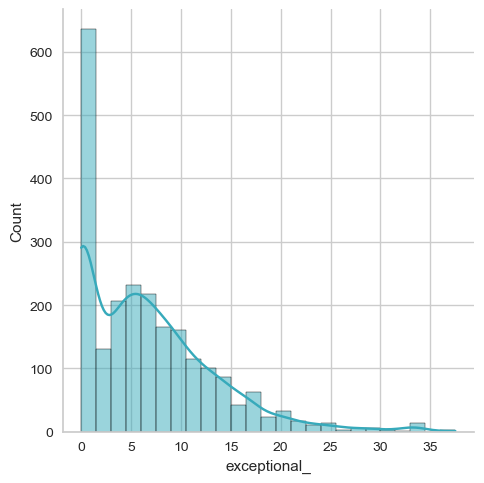

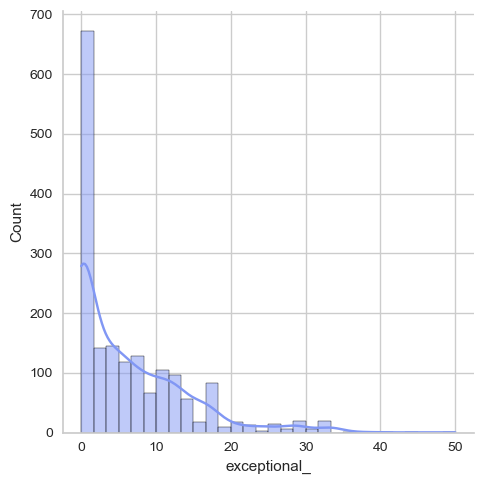

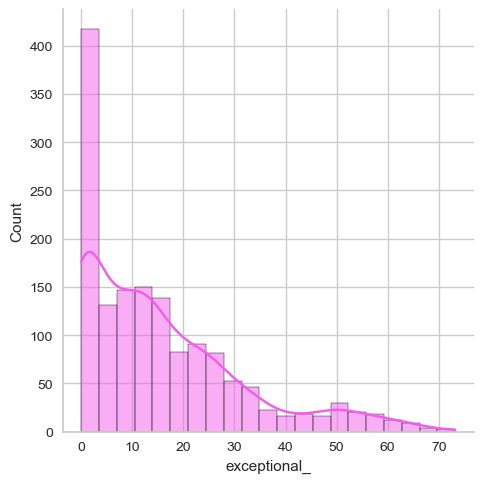

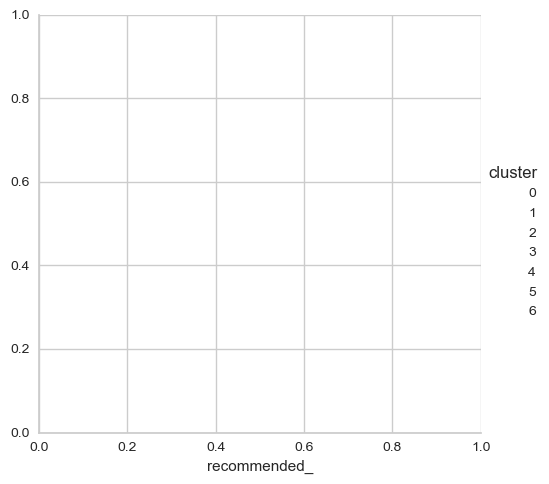

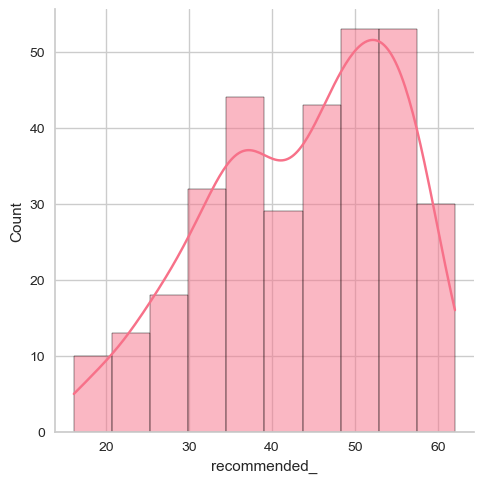

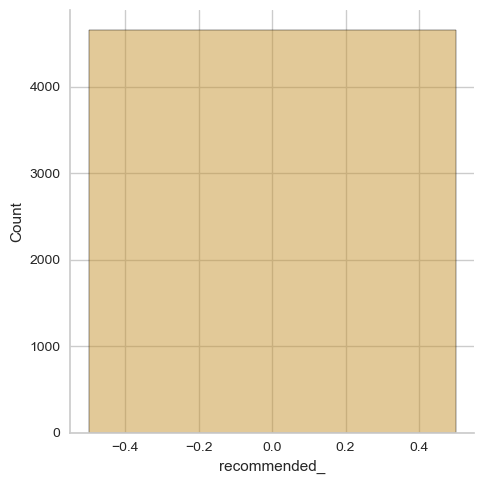

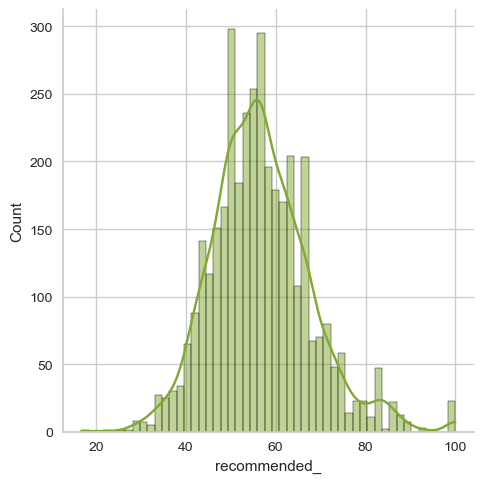

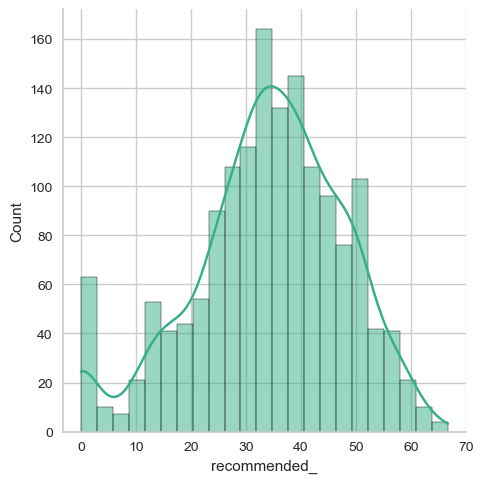

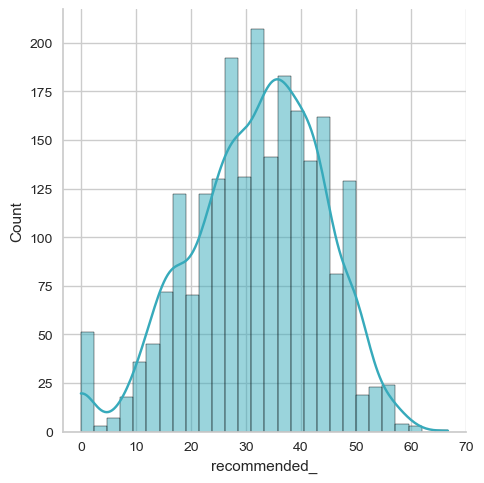

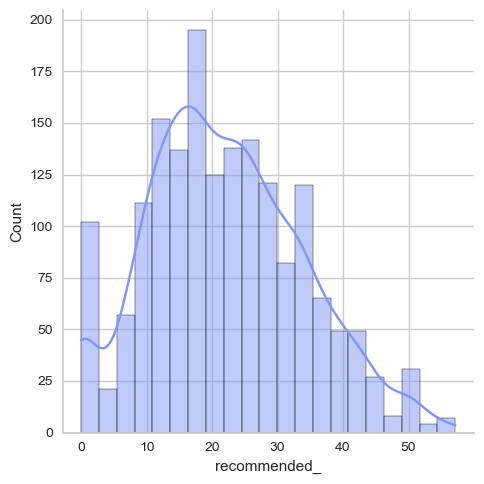

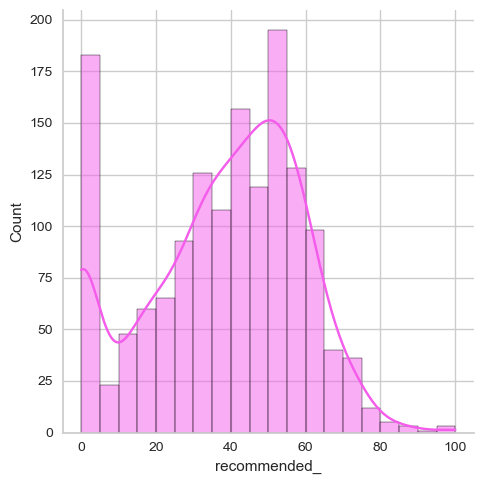

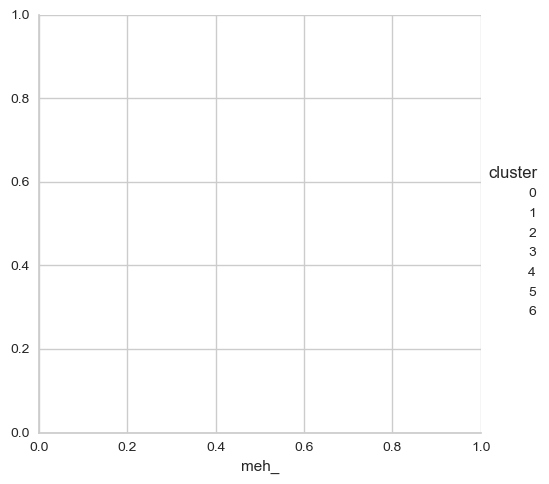

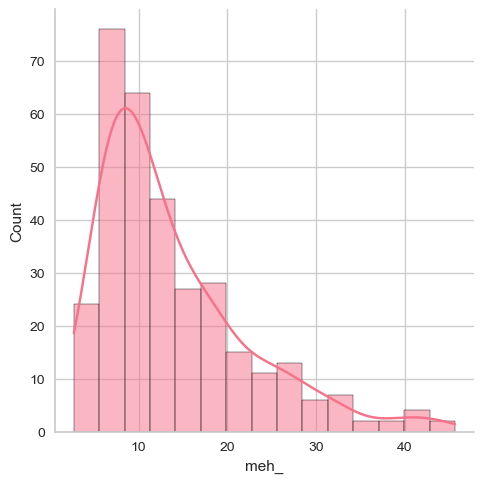

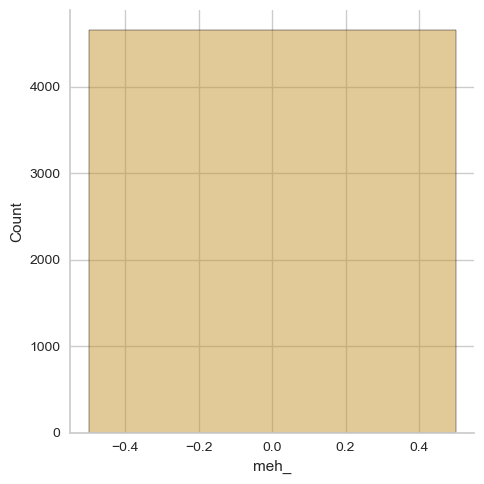

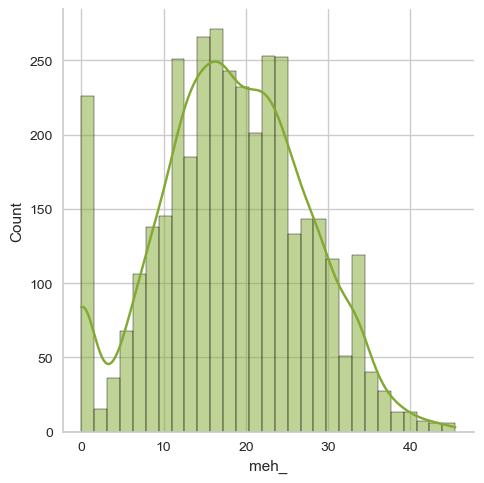

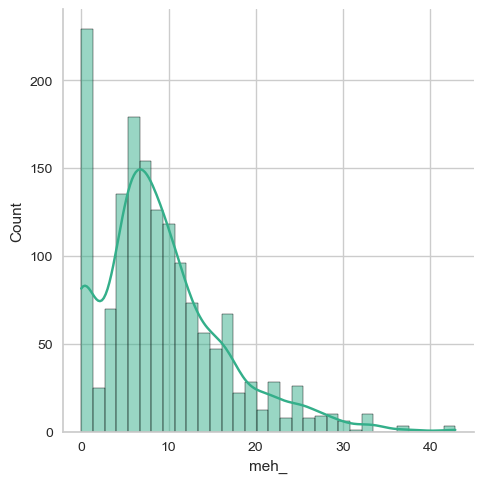

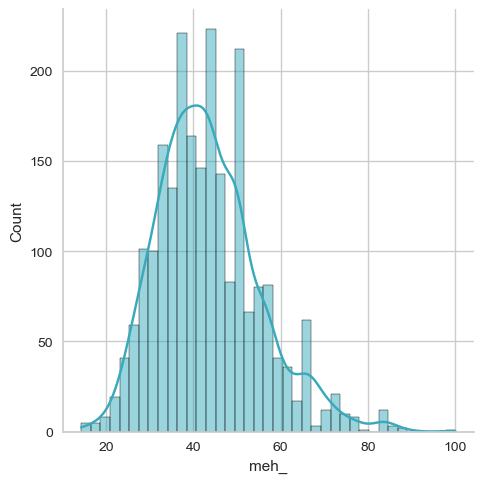

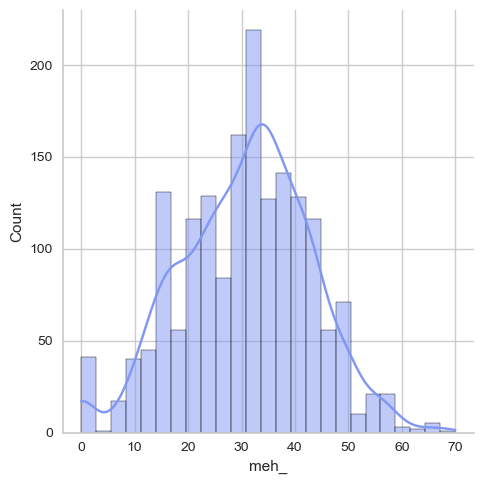

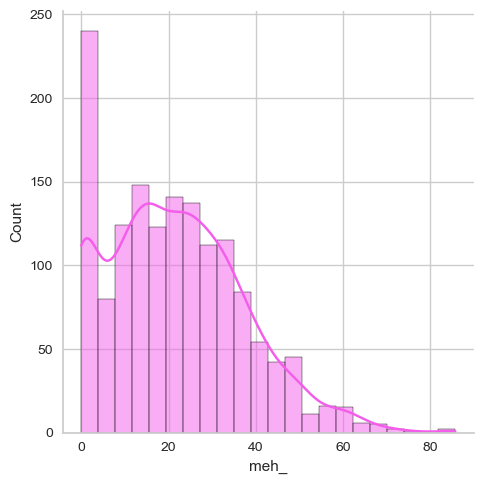

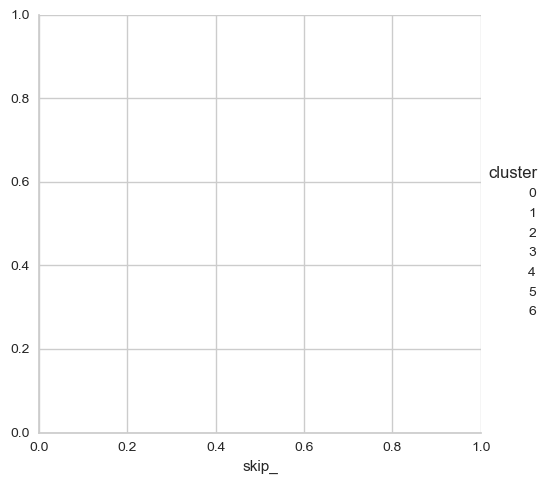

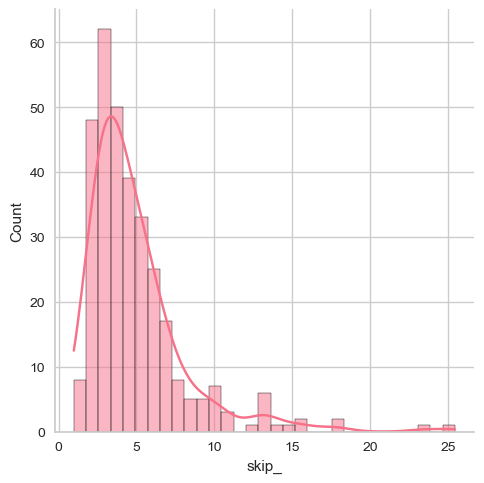

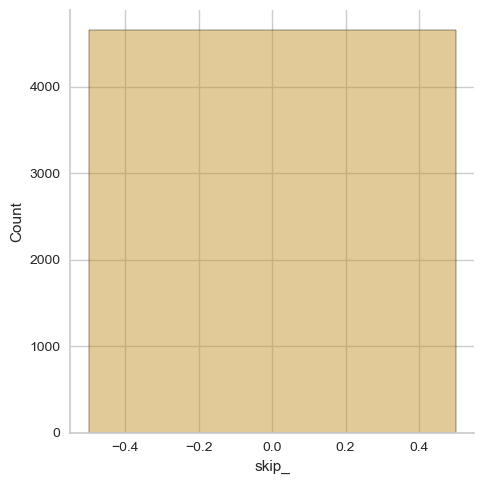

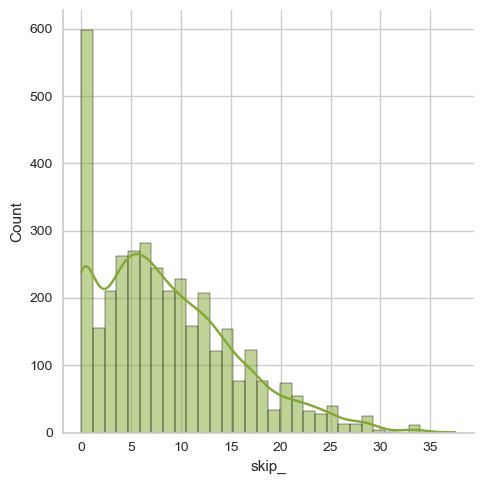

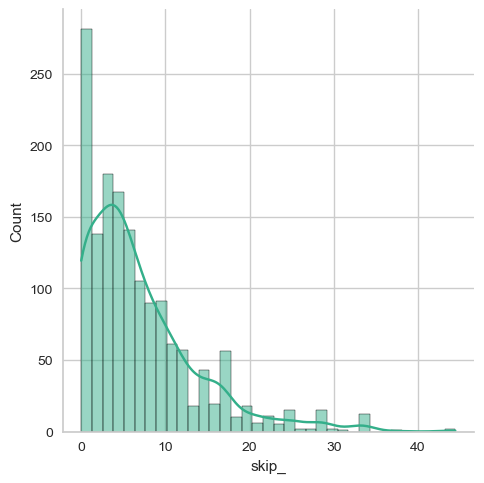

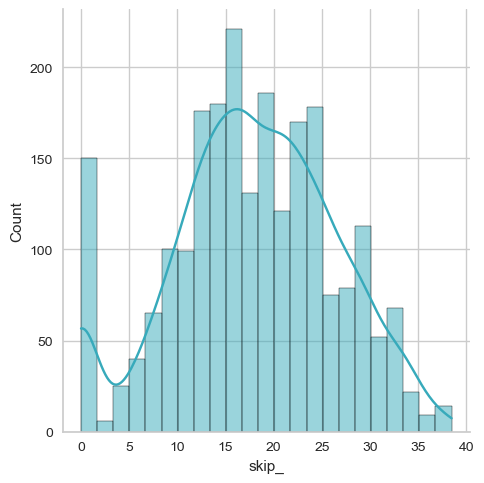

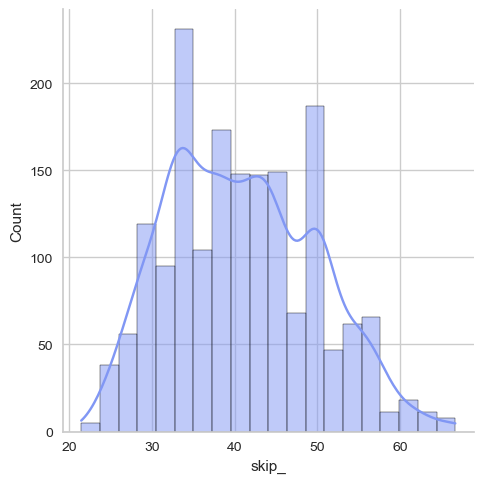

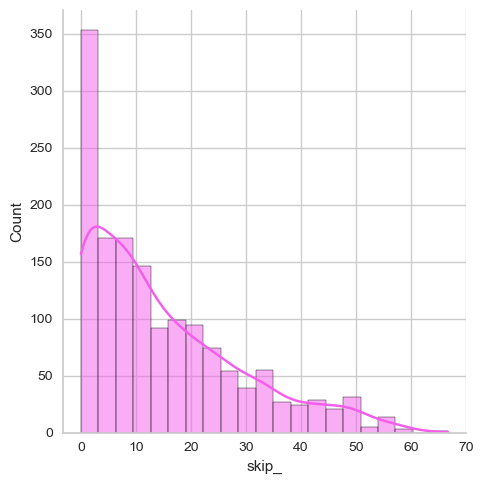

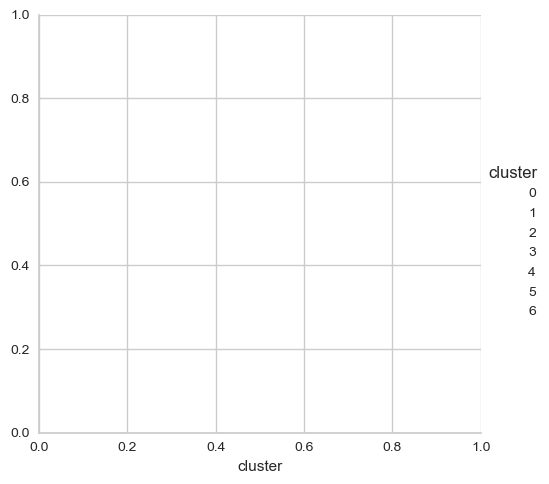

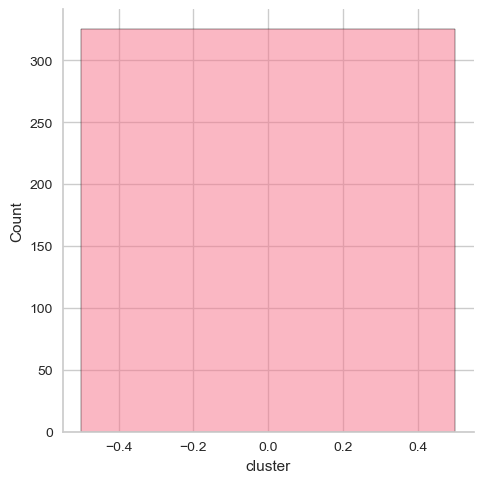

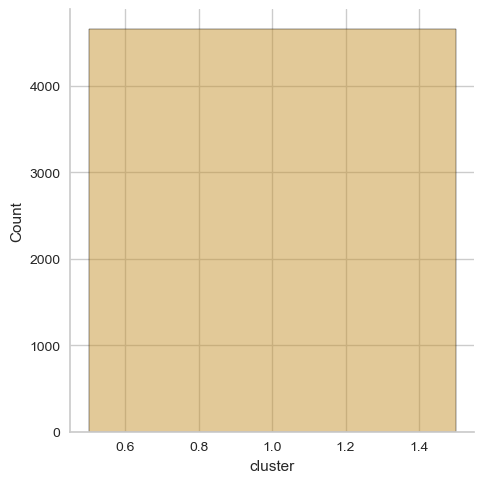

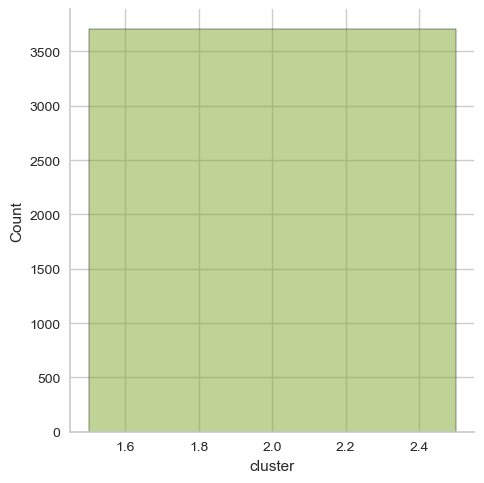

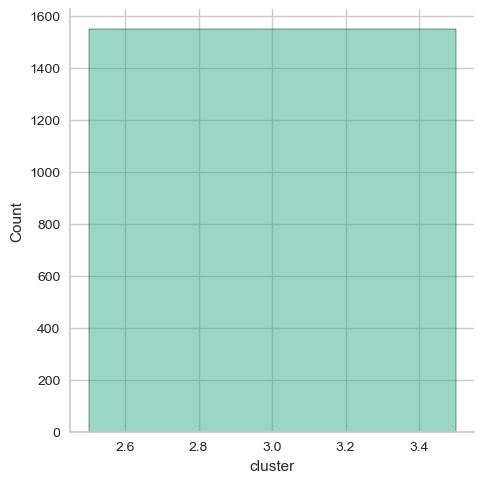

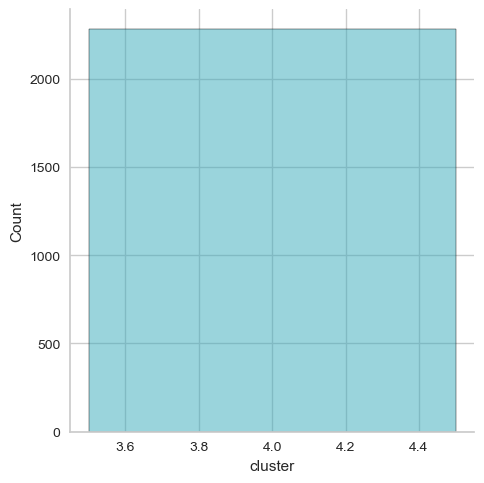

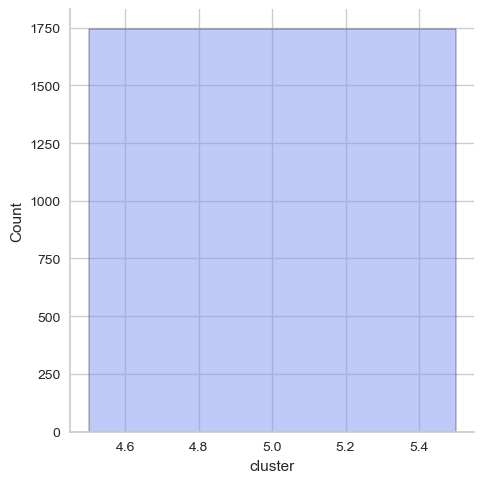

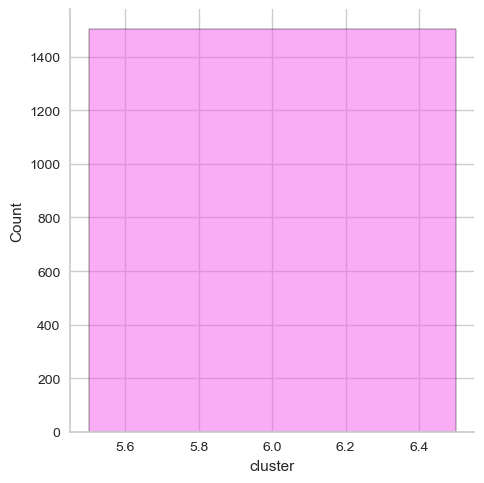

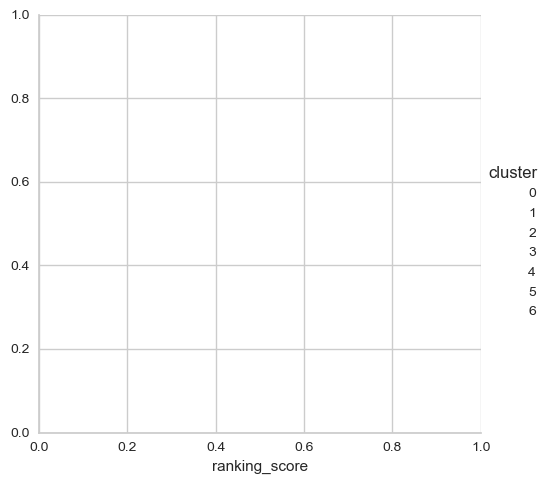

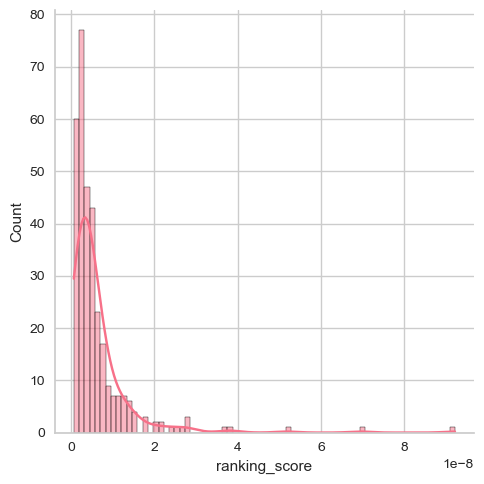

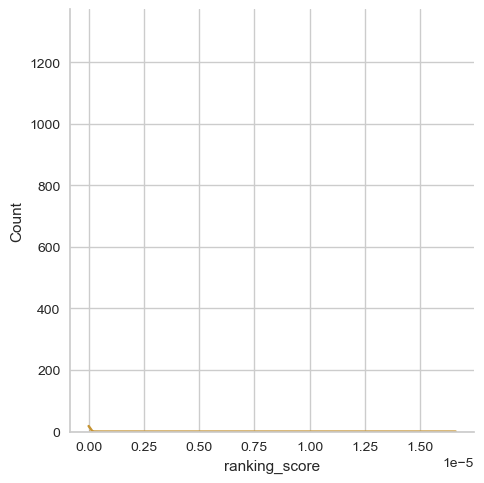

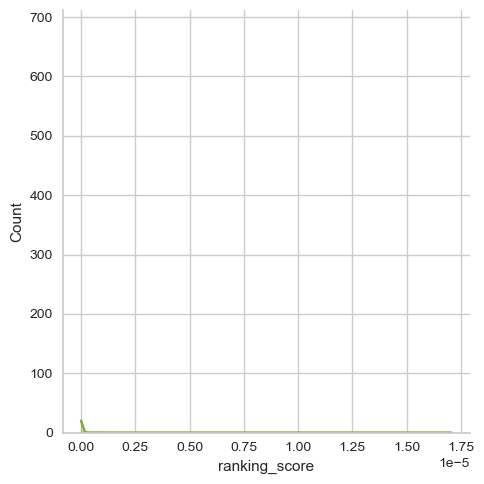

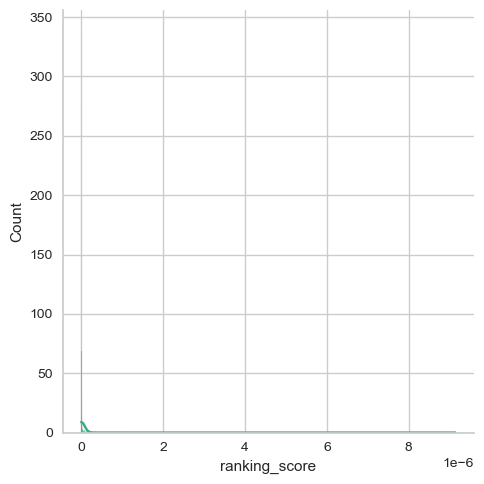

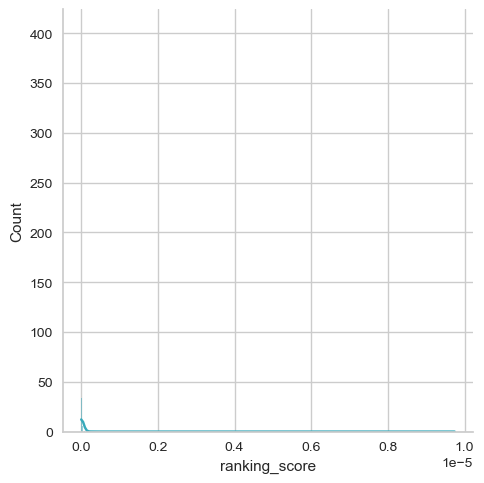

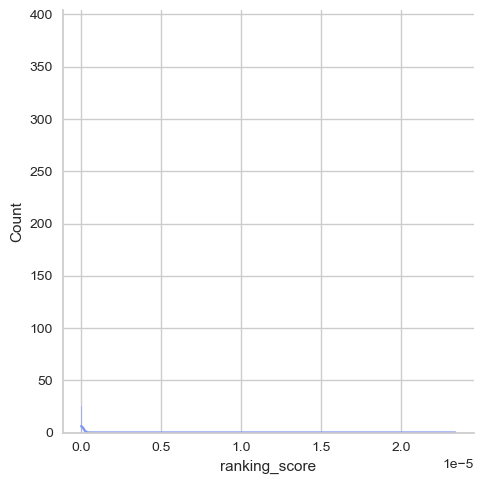

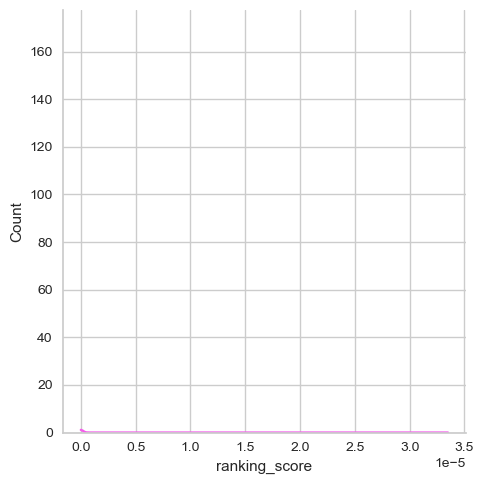

In [83]:
for feature in numericals.columns:
    sns.FacetGrid(numericals, hue="cluster", height=5).map(sns.displot, feature, kde=True).add_legend()
    plt.show()

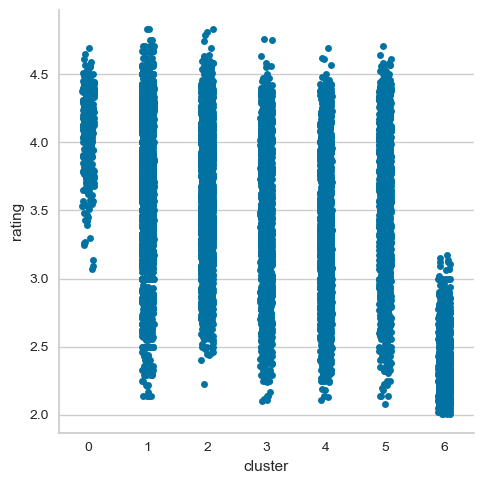

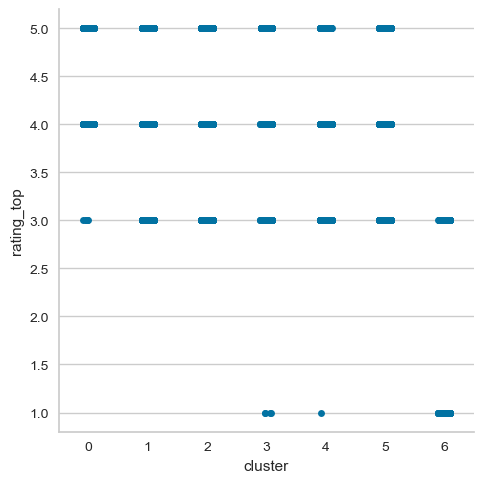

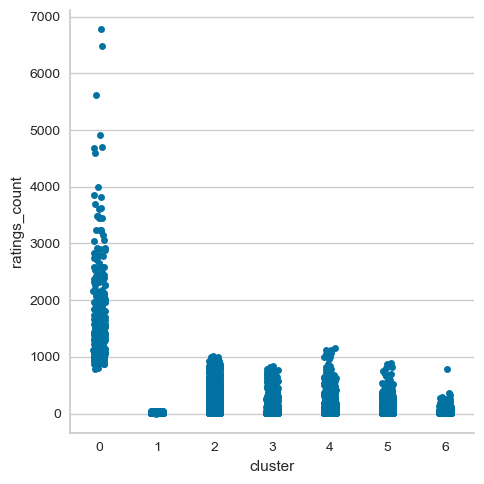

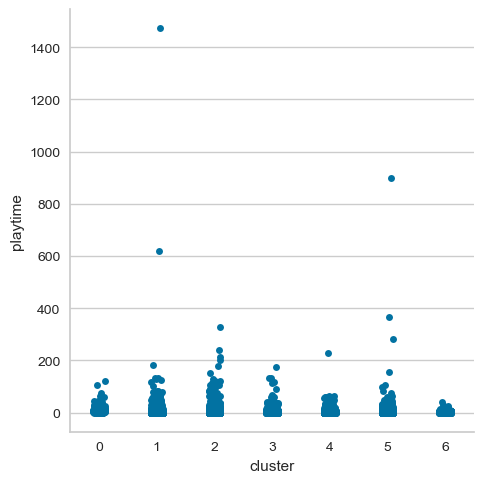

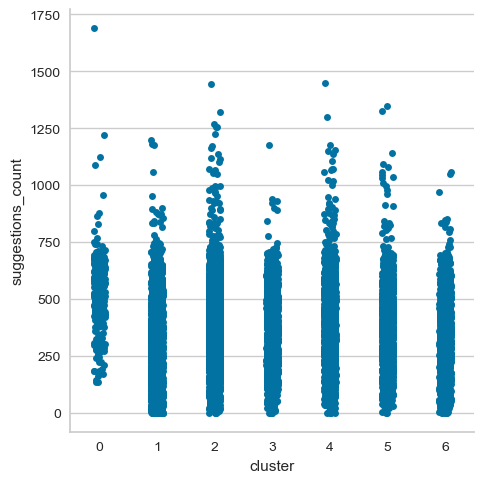

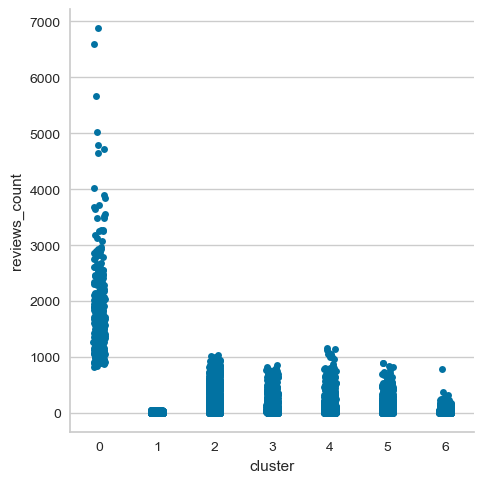

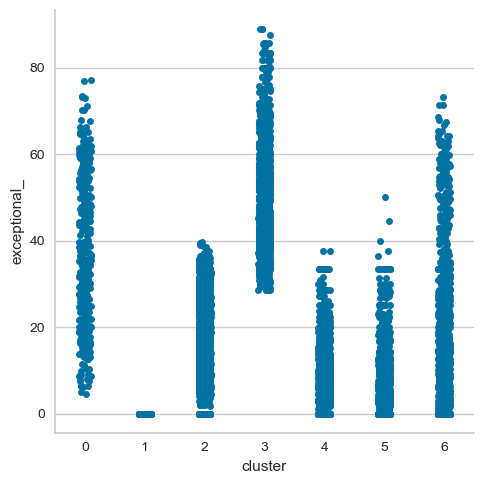

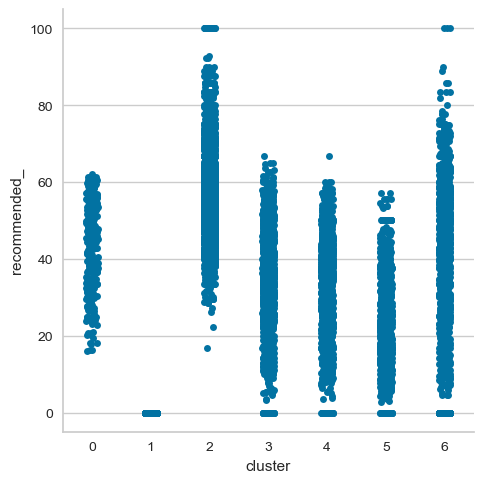

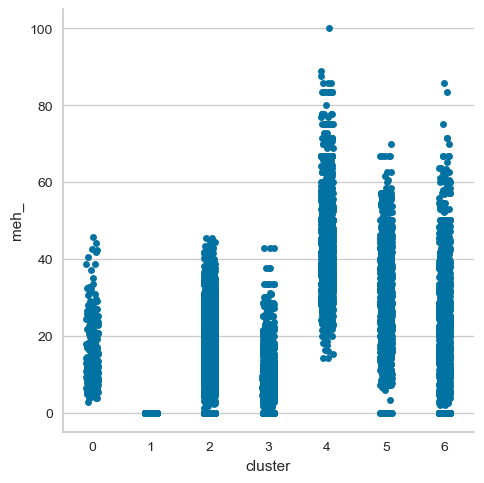

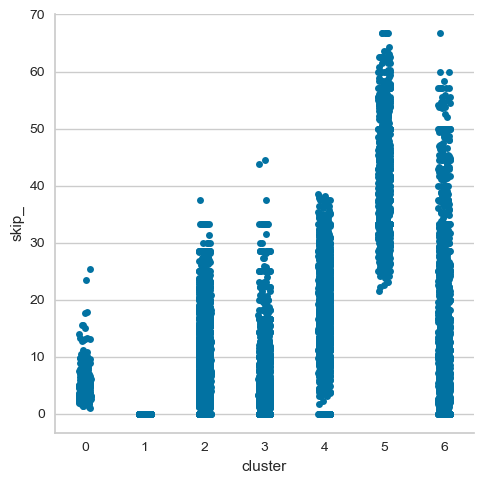

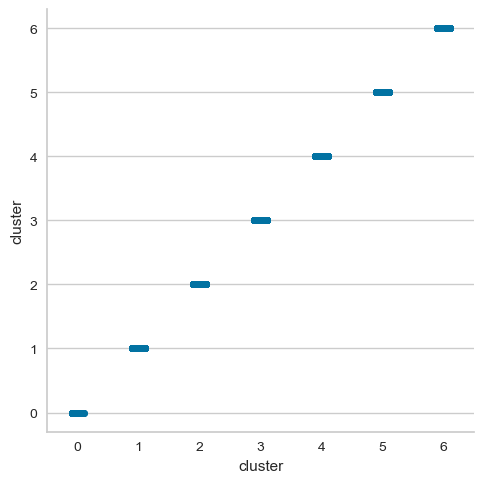

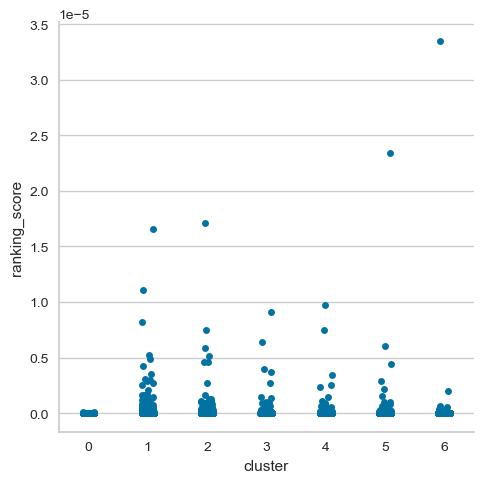

In [86]:
for col in numericals.columns:
    sns.catplot(x="cluster", y=f"{col}", data=numericals) 
    plt.show()

In [69]:
numericals.isna().sum()

rating                0
rating_top            0
ratings_count         0
playtime              0
suggestions_count     0
reviews_count         0
exceptional_          0
recommended_          0
meh_                  0
skip_                 0
cluster               0
ranking_score        14
dtype: int64

In [64]:
len(combined_df.columns)

25